In [68]:
from common import *
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from matplotlib import pyplot as plt
import logging, time
from sklearn.model_selection import train_test_split
import data_flow
import train
import gc

# Prepare data

In [2]:
fnames = glob('../data/corpus/**.txt')

In [134]:
word_embeddings = np.load(join(DATA_FOLDER, 'word_embeddings_300.npy'))
with open(join(DATA_FOLDER, "dictionary.pickle"), "rb") as input_file:
    index2word = pickle.load(input_file)

In [143]:
docs = []
ids = []
for fn in tqdm_notebook(fnames[:]):
    with open(fn, 'rb') as f:
        ixs = [int(_ix) for _ix in f.read().split()]
    if len(ixs) == 0:
        print(fn)
        continue
    doc_vec = word_embeddings[ixs].mean(axis=0)
    docs.append(doc_vec)
    ids.append(basename(fn).split('.')[0])

../data/corpus/5984b653b6b11311aa638537.txt
../data/corpus/5984b69db6b1131591638547.txt
../data/corpus/5984b6fdb6b1131ae26384f4.txt
../data/corpus/5984b667b6b11313926384f7.txt
../data/corpus/5984b690b6b113159263850f.txt
../data/corpus/5984b65db6b1131294638541.txt
../data/corpus/5984b6bab6b11317b963851c.txt
../data/corpus/5984b592b6b113049f638531.txt
../data/corpus/5984b6bab6b11317a16384fd.txt
../data/corpus/5984b6a3b6b11316a563850e.txt
../data/corpus/5984b589b6b11304986384fd.txt
../data/corpus/5984b6c1b6b11317b0638527.txt
../data/corpus/5984b6bbb6b11317a163852f.txt
../data/corpus/5984b6bbb6b11317a1638546.txt
../data/corpus/5984b58fb6b1130489638517.txt
../data/corpus/5984b68fb6b11315926384f3.txt
../data/corpus/5984b68fb6b1131592638508.txt
../data/corpus/5984b58fb6b11304a963852e.txt
../data/corpus/5984b6bbb6b11317a1638536.txt
../data/corpus/5984b6a4b6b113169a638532.txt
../data/corpus/5984b6bab6b11317a163850f.txt
../data/corpus/5984b6c2b6b11317b8638545.txt
../data/corpus/5984b6c1b6b11317b

In [146]:
np.save('../data/avged_docs.npy', docs)
np.save('../data/avged_ids.npy', ids)

# Load data

In [2]:
with open(join(DATA_FOLDER, 'sims.json'), 'r') as f:
    sims = json.load(f)
with open(join(DATA_FOLDER, 'gold_mongo.json'), 'r') as f:
    gold = json.load(f)

In [51]:
_docs = np.load('../data/avged_docs.npy')
ids = np.load('../data/avged_ids.npy')
docs = pd.DataFrame(_docs, index=ids)
docs.sort_index(inplace=True)

# try unsupervised

In [53]:
val_vecs = []
for _id in tqdm_notebook(gold.keys()):
    ix = np.where(ids == _id)[0][0]
    val_vecs.append(_docs[ix])

In [54]:
sim_mat = cosine_similarity(val_vecs, _docs)

In [56]:
best = {}
for i, vec in enumerate(tqdm_notebook(sim_mat)):
    val_name = gold.keys()[i]
    train_ixs = vec.argsort()[-200:][::-1]
    top_train = [ids[i] for i in train_ixs]
    best[val_name] = top_train

100%|██████████| 184/184 [00:00<00:00, 34894.06it/s]

median
acc10     0.0
acc20     0.0
acc200    0.5
dtype: float64
mean
acc10     0.273007
acc20     0.355435
acc200    0.535145
dtype: float64


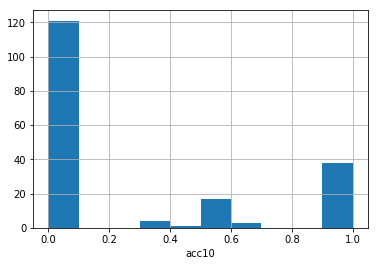

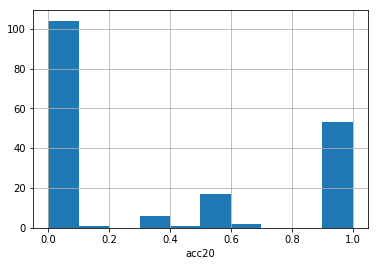

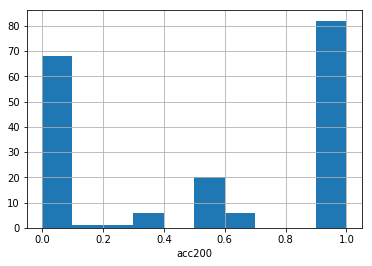

In [58]:
result = evaluate(best, gold)

ax = result['acc10'].hist()
ax.set_xlabel("acc10")
plt.show()

ax = result['acc20'].hist()
ax.set_xlabel("acc20")
plt.show()

ax = result['acc200'].hist()
ax.set_xlabel("acc200")
plt.show()

# try supervised

In [4]:
triples_all = list(data_flow.random_triples(sims, ids, num_epochs=1, with_path=False, seed=1))
_triples, triples_test = train_test_split(triples_all, test_size=0.1, random_state=0)
triples_train, triples_val = train_test_split(_triples, test_size=0.1, random_state=0)
gc.collect()

100%|██████████| 368458/368458 [00:04<00:00, 87415.00it/s] 


0

In [5]:
embedding_size = 300
batch_size = 64
learning_rate = 0.1
sizes=[300, 200]

In [74]:
reload(train)

logging.info('start training ...')
start_time = time.time()

finished = False
try:
    tf.reset_default_graph()
    tf.set_random_seed(0)
    session_conf = tf.ConfigProto(
        allow_soft_placement=True, log_device_placement=False)
    sess = tf.Session(config=session_conf)
    with sess.as_default():
        X = tf.placeholder('float32', (None, embedding_size), name='X')

        model = train.FCNN(batch_size=batch_size, sizes=sizes, 
                        learning_rate=learning_rate,
                        batch_norm=True)
        train_op = model.optimize(X)

        init_local = tf.local_variables_initializer()
        init_global = tf.global_variables_initializer()
        sess.run([init_global, init_local])

        model.init_summary('train')
#         model.init_summary('val')

        tr_batch = data_flow.gen_batches(docs, triples_train[:], batch_size)
#         val_batch = data_flow.gen_batches(docs, triples_val, 64)

        for step, X_train in enumerate(tr_batch):
            assert not X_train.isnull().values.any()
            _, loss, summary, _embeds = sess.run([
                train_op, model.loss_op,
                model.merged_summary_op, model.negative
            ], feed_dict = {model.phase: 1, 'X:0': X_train})
            model.add_summary(summary, step)
            logging.info('step %s, loss %s' % (step, loss))
            
#             if (step + 1) %  50 == 0:
#                 X_val = next(val_batch)
#                 [val_loss] = sess.run([loss], 
#                               feed_dict={'X:0': X_val,
#                                          'phase:0': 0})
#             if (step + 1) %  50 == 0:
#                 [test_loss, t20, t200] = sess.run([loss, top20, top200], 
#                              feed_dict={'X:0': X_test,
#                                         'phase:0': 0})
        model.save(step)
        finished = True

except Exception as e:
    logging.exception("train error")
#     send_email('notebook_url', subject='train error', body=e)
finally:
    if finished:
#     send_email('notebook_url', subject='finished training')
        pass
        
logging.info("--- %s seconds ---" % (time.time() - start_time))

2017-09-26 13:29:04,839 [MainThread  ] [INFO ]  start training ...
2017-09-26 13:29:18,333 [MainThread  ] [INFO ]  step 0, loss 0.00776941
2017-09-26 13:29:18,354 [MainThread  ] [INFO ]  step 1, loss 0.0174367
2017-09-26 13:29:18,484 [MainThread  ] [INFO ]  step 2, loss 0.0871114
2017-09-26 13:29:18,506 [MainThread  ] [INFO ]  step 3, loss 0.0318647
2017-09-26 13:29:18,524 [MainThread  ] [INFO ]  step 4, loss 0.0615518
2017-09-26 13:29:18,545 [MainThread  ] [INFO ]  step 5, loss 0.0352434
2017-09-26 13:29:18,567 [MainThread  ] [INFO ]  step 6, loss 0.0126087
2017-09-26 13:29:18,587 [MainThread  ] [INFO ]  step 7, loss 0.0394958
2017-09-26 13:29:18,606 [MainThread  ] [INFO ]  step 8, loss 0.0391591
2017-09-26 13:29:18,622 [MainThread  ] [INFO ]  step 9, loss 0.0278647
2017-09-26 13:29:18,647 [MainThread  ] [INFO ]  step 10, loss 0.0188044
2017-09-26 13:29:18,673 [MainThread  ] [INFO ]  step 11, loss 0.0441147
2017-09-26 13:29:18,692 [MainThread  ] [INFO ]  step 12, loss 0.0469828
2017-0

2017-09-26 13:29:21,416 [MainThread  ] [INFO ]  step 113, loss 0.00774356
2017-09-26 13:29:21,436 [MainThread  ] [INFO ]  step 114, loss 0.0221471
2017-09-26 13:29:21,451 [MainThread  ] [INFO ]  step 115, loss 0.00953967
2017-09-26 13:29:21,467 [MainThread  ] [INFO ]  step 116, loss 0.00278838
2017-09-26 13:29:21,483 [MainThread  ] [INFO ]  step 117, loss 0.0171061
2017-09-26 13:29:21,499 [MainThread  ] [INFO ]  step 118, loss 0.0149564
2017-09-26 13:29:21,620 [MainThread  ] [INFO ]  step 119, loss 0.0174422
2017-09-26 13:29:21,635 [MainThread  ] [INFO ]  step 120, loss 0.00363128
2017-09-26 13:29:21,651 [MainThread  ] [INFO ]  step 121, loss 0.00969537
2017-09-26 13:29:21,671 [MainThread  ] [INFO ]  step 122, loss 0.0190014
2017-09-26 13:29:21,686 [MainThread  ] [INFO ]  step 123, loss 0.00160643
2017-09-26 13:29:21,701 [MainThread  ] [INFO ]  step 124, loss 0.00123565
2017-09-26 13:29:21,720 [MainThread  ] [INFO ]  step 125, loss 0.0161294
2017-09-26 13:29:21,733 [MainThread  ] [INFO

2017-09-26 13:29:24,347 [MainThread  ] [INFO ]  step 225, loss 0.0274105
2017-09-26 13:29:24,367 [MainThread  ] [INFO ]  step 226, loss 0.0104957
2017-09-26 13:29:24,386 [MainThread  ] [INFO ]  step 227, loss 0.00133922
2017-09-26 13:29:24,406 [MainThread  ] [INFO ]  step 228, loss 0.00140568
2017-09-26 13:29:24,421 [MainThread  ] [INFO ]  step 229, loss 0.0
2017-09-26 13:29:24,442 [MainThread  ] [INFO ]  step 230, loss 0.000664505
2017-09-26 13:29:24,461 [MainThread  ] [INFO ]  step 231, loss 0.00133724
2017-09-26 13:29:24,478 [MainThread  ] [INFO ]  step 232, loss 0.0141007
2017-09-26 13:29:24,496 [MainThread  ] [INFO ]  step 233, loss 0.00177726
2017-09-26 13:29:24,526 [MainThread  ] [INFO ]  step 234, loss 0.0155714
2017-09-26 13:29:24,543 [MainThread  ] [INFO ]  step 235, loss 0.00611258
2017-09-26 13:29:24,562 [MainThread  ] [INFO ]  step 236, loss 0.00355413
2017-09-26 13:29:24,579 [MainThread  ] [INFO ]  step 237, loss 0.015713
2017-09-26 13:29:24,704 [MainThread  ] [INFO ]  st

2017-09-26 13:29:27,223 [MainThread  ] [INFO ]  step 337, loss 0.00843272
2017-09-26 13:29:27,243 [MainThread  ] [INFO ]  step 338, loss 0.00757036
2017-09-26 13:29:27,262 [MainThread  ] [INFO ]  step 339, loss 0.00676652
2017-09-26 13:29:27,283 [MainThread  ] [INFO ]  step 340, loss 0.00396891
2017-09-26 13:29:27,301 [MainThread  ] [INFO ]  step 341, loss 0.00681026
2017-09-26 13:29:27,318 [MainThread  ] [INFO ]  step 342, loss 0.00608389
2017-09-26 13:29:27,335 [MainThread  ] [INFO ]  step 343, loss 0.00322696
2017-09-26 13:29:27,353 [MainThread  ] [INFO ]  step 344, loss 0.00933555
2017-09-26 13:29:27,369 [MainThread  ] [INFO ]  step 345, loss 0.00444189
2017-09-26 13:29:27,387 [MainThread  ] [INFO ]  step 346, loss 0.0217315
2017-09-26 13:29:27,410 [MainThread  ] [INFO ]  step 347, loss 0.0101653
2017-09-26 13:29:27,425 [MainThread  ] [INFO ]  step 348, loss 0.0097762
2017-09-26 13:29:27,439 [MainThread  ] [INFO ]  step 349, loss 0.0046051
2017-09-26 13:29:27,456 [MainThread  ] [IN

2017-09-26 13:29:30,476 [MainThread  ] [INFO ]  step 449, loss 0.00932372
2017-09-26 13:29:30,500 [MainThread  ] [INFO ]  step 450, loss 0.0
2017-09-26 13:29:30,518 [MainThread  ] [INFO ]  step 451, loss 0.00555701
2017-09-26 13:29:30,538 [MainThread  ] [INFO ]  step 452, loss 0.00754242
2017-09-26 13:29:30,554 [MainThread  ] [INFO ]  step 453, loss 0.00249312
2017-09-26 13:29:30,571 [MainThread  ] [INFO ]  step 454, loss 0.00513231
2017-09-26 13:29:30,588 [MainThread  ] [INFO ]  step 455, loss 0.02447
2017-09-26 13:29:30,605 [MainThread  ] [INFO ]  step 456, loss 0.00563785
2017-09-26 13:29:30,621 [MainThread  ] [INFO ]  step 457, loss 0.00289086
2017-09-26 13:29:30,638 [MainThread  ] [INFO ]  step 458, loss 0.0153566
2017-09-26 13:29:30,654 [MainThread  ] [INFO ]  step 459, loss 0.00117658
2017-09-26 13:29:30,776 [MainThread  ] [INFO ]  step 460, loss 0.0110101
2017-09-26 13:29:30,795 [MainThread  ] [INFO ]  step 461, loss 0.02389
2017-09-26 13:29:30,814 [MainThread  ] [INFO ]  step 

2017-09-26 13:29:33,870 [MainThread  ] [INFO ]  step 562, loss 0.0342578
2017-09-26 13:29:33,887 [MainThread  ] [INFO ]  step 563, loss 0.00652706
2017-09-26 13:29:33,903 [MainThread  ] [INFO ]  step 564, loss 0.0178548
2017-09-26 13:29:34,026 [MainThread  ] [INFO ]  step 565, loss 0.00551345
2017-09-26 13:29:34,045 [MainThread  ] [INFO ]  step 566, loss 0.0130555
2017-09-26 13:29:34,061 [MainThread  ] [INFO ]  step 567, loss 0.00230797
2017-09-26 13:29:34,077 [MainThread  ] [INFO ]  step 568, loss 0.00158251
2017-09-26 13:29:34,093 [MainThread  ] [INFO ]  step 569, loss 0.00401984
2017-09-26 13:29:34,109 [MainThread  ] [INFO ]  step 570, loss 0.00773763
2017-09-26 13:29:34,124 [MainThread  ] [INFO ]  step 571, loss 0.028711
2017-09-26 13:29:34,139 [MainThread  ] [INFO ]  step 572, loss 0.0
2017-09-26 13:29:34,154 [MainThread  ] [INFO ]  step 573, loss 0.0136127
2017-09-26 13:29:34,170 [MainThread  ] [INFO ]  step 574, loss 0.0177996
2017-09-26 13:29:34,301 [MainThread  ] [INFO ]  step

2017-09-26 13:29:37,070 [MainThread  ] [INFO ]  step 675, loss 0.0
2017-09-26 13:29:37,086 [MainThread  ] [INFO ]  step 676, loss 0.0124144
2017-09-26 13:29:37,106 [MainThread  ] [INFO ]  step 677, loss 0.0226599
2017-09-26 13:29:37,121 [MainThread  ] [INFO ]  step 678, loss 0.0106367
2017-09-26 13:29:37,138 [MainThread  ] [INFO ]  step 679, loss 0.0140209
2017-09-26 13:29:37,260 [MainThread  ] [INFO ]  step 680, loss 0.00711239
2017-09-26 13:29:37,278 [MainThread  ] [INFO ]  step 681, loss 0.00453912
2017-09-26 13:29:37,294 [MainThread  ] [INFO ]  step 682, loss 0.0189716
2017-09-26 13:29:37,309 [MainThread  ] [INFO ]  step 683, loss 0.00634578
2017-09-26 13:29:37,325 [MainThread  ] [INFO ]  step 684, loss 0.00299279
2017-09-26 13:29:37,343 [MainThread  ] [INFO ]  step 685, loss 0.00290423
2017-09-26 13:29:37,360 [MainThread  ] [INFO ]  step 686, loss 0.0401708
2017-09-26 13:29:37,375 [MainThread  ] [INFO ]  step 687, loss 0.00701654
2017-09-26 13:29:37,391 [MainThread  ] [INFO ]  ste

2017-09-26 13:29:40,008 [MainThread  ] [INFO ]  step 788, loss 0.0110388
2017-09-26 13:29:40,025 [MainThread  ] [INFO ]  step 789, loss 0.00214104
2017-09-26 13:29:40,040 [MainThread  ] [INFO ]  step 790, loss 0.0120346
2017-09-26 13:29:40,057 [MainThread  ] [INFO ]  step 791, loss 0.0184688
2017-09-26 13:29:40,075 [MainThread  ] [INFO ]  step 792, loss 0.0055389
2017-09-26 13:29:40,093 [MainThread  ] [INFO ]  step 793, loss 0.0161144
2017-09-26 13:29:40,211 [MainThread  ] [INFO ]  step 794, loss 0.0250568
2017-09-26 13:29:40,227 [MainThread  ] [INFO ]  step 795, loss 0.00519926
2017-09-26 13:29:40,244 [MainThread  ] [INFO ]  step 796, loss 0.0
2017-09-26 13:29:40,261 [MainThread  ] [INFO ]  step 797, loss 0.00236486
2017-09-26 13:29:40,275 [MainThread  ] [INFO ]  step 798, loss 0.00971407
2017-09-26 13:29:40,393 [MainThread  ] [INFO ]  step 799, loss 0.00620139
2017-09-26 13:29:40,408 [MainThread  ] [INFO ]  step 800, loss 0.0011959
2017-09-26 13:29:40,424 [MainThread  ] [INFO ]  step

2017-09-26 13:29:43,577 [MainThread  ] [INFO ]  step 900, loss 0.0192705
2017-09-26 13:29:43,596 [MainThread  ] [INFO ]  step 901, loss 0.0267102
2017-09-26 13:29:43,611 [MainThread  ] [INFO ]  step 902, loss 0.0087818
2017-09-26 13:29:43,627 [MainThread  ] [INFO ]  step 903, loss 0.0034219
2017-09-26 13:29:43,741 [MainThread  ] [INFO ]  step 904, loss 0.0142434
2017-09-26 13:29:43,761 [MainThread  ] [INFO ]  step 905, loss 0.0111751
2017-09-26 13:29:43,782 [MainThread  ] [INFO ]  step 906, loss 0.0030869
2017-09-26 13:29:43,801 [MainThread  ] [INFO ]  step 907, loss 0.00635468
2017-09-26 13:29:43,818 [MainThread  ] [INFO ]  step 908, loss 0.0152348
2017-09-26 13:29:43,835 [MainThread  ] [INFO ]  step 909, loss 0.000145366
2017-09-26 13:29:43,855 [MainThread  ] [INFO ]  step 910, loss 0.0
2017-09-26 13:29:43,872 [MainThread  ] [INFO ]  step 911, loss 0.0155395
2017-09-26 13:29:43,990 [MainThread  ] [INFO ]  step 912, loss 0.00838222
2017-09-26 13:29:44,005 [MainThread  ] [INFO ]  step 

2017-09-26 13:29:46,808 [MainThread  ] [INFO ]  step 1012, loss 0.0141897
2017-09-26 13:29:46,828 [MainThread  ] [INFO ]  step 1013, loss 0.00326781
2017-09-26 13:29:46,845 [MainThread  ] [INFO ]  step 1014, loss 0.00398734
2017-09-26 13:29:46,862 [MainThread  ] [INFO ]  step 1015, loss 0.00657628
2017-09-26 13:29:46,877 [MainThread  ] [INFO ]  step 1016, loss 0.00243632
2017-09-26 13:29:46,896 [MainThread  ] [INFO ]  step 1017, loss 0.0225951
2017-09-26 13:29:46,911 [MainThread  ] [INFO ]  step 1018, loss 0.0295369
2017-09-26 13:29:46,926 [MainThread  ] [INFO ]  step 1019, loss 0.0173898
2017-09-26 13:29:46,947 [MainThread  ] [INFO ]  step 1020, loss 0.000912764
2017-09-26 13:29:46,962 [MainThread  ] [INFO ]  step 1021, loss 0.00799381
2017-09-26 13:29:46,978 [MainThread  ] [INFO ]  step 1022, loss 0.0119412
2017-09-26 13:29:46,992 [MainThread  ] [INFO ]  step 1023, loss 0.0157606
2017-09-26 13:29:47,009 [MainThread  ] [INFO ]  step 1024, loss 0.00821178
2017-09-26 13:29:47,024 [MainT

2017-09-26 13:29:49,123 [MainThread  ] [INFO ]  step 1123, loss 0.00229352
2017-09-26 13:29:49,140 [MainThread  ] [INFO ]  step 1124, loss 0.00824117
2017-09-26 13:29:49,155 [MainThread  ] [INFO ]  step 1125, loss 0.0153514
2017-09-26 13:29:49,171 [MainThread  ] [INFO ]  step 1126, loss 0.0221375
2017-09-26 13:29:49,187 [MainThread  ] [INFO ]  step 1127, loss 0.00265632
2017-09-26 13:29:49,202 [MainThread  ] [INFO ]  step 1128, loss 0.00103152
2017-09-26 13:29:49,216 [MainThread  ] [INFO ]  step 1129, loss 0.00976086
2017-09-26 13:29:49,233 [MainThread  ] [INFO ]  step 1130, loss 0.00309672
2017-09-26 13:29:49,248 [MainThread  ] [INFO ]  step 1131, loss 0.0285871
2017-09-26 13:29:49,375 [MainThread  ] [INFO ]  step 1132, loss 0.0
2017-09-26 13:29:49,391 [MainThread  ] [INFO ]  step 1133, loss 0.0045536
2017-09-26 13:29:49,407 [MainThread  ] [INFO ]  step 1134, loss 0.00619672
2017-09-26 13:29:49,423 [MainThread  ] [INFO ]  step 1135, loss 0.0083118
2017-09-26 13:29:49,439 [MainThread  

2017-09-26 13:29:52,551 [MainThread  ] [INFO ]  step 1234, loss 0.0358347
2017-09-26 13:29:52,676 [MainThread  ] [INFO ]  step 1235, loss 0.0
2017-09-26 13:29:52,697 [MainThread  ] [INFO ]  step 1236, loss 0.00187043
2017-09-26 13:29:52,718 [MainThread  ] [INFO ]  step 1237, loss 0.01545
2017-09-26 13:29:52,733 [MainThread  ] [INFO ]  step 1238, loss 0.0083968
2017-09-26 13:29:52,750 [MainThread  ] [INFO ]  step 1239, loss 0.0059398
2017-09-26 13:29:52,765 [MainThread  ] [INFO ]  step 1240, loss 0.00664039
2017-09-26 13:29:52,780 [MainThread  ] [INFO ]  step 1241, loss 0.0113951
2017-09-26 13:29:52,807 [MainThread  ] [INFO ]  step 1242, loss 0.00398994
2017-09-26 13:29:52,929 [MainThread  ] [INFO ]  step 1243, loss 0.00417175
2017-09-26 13:29:52,946 [MainThread  ] [INFO ]  step 1244, loss 0.00965138
2017-09-26 13:29:52,961 [MainThread  ] [INFO ]  step 1245, loss 0.0166021
2017-09-26 13:29:52,977 [MainThread  ] [INFO ]  step 1246, loss 0.017781
2017-09-26 13:29:52,992 [MainThread  ] [IN

2017-09-26 13:29:55,013 [MainThread  ] [INFO ]  step 1345, loss 0.0
2017-09-26 13:29:55,031 [MainThread  ] [INFO ]  step 1346, loss 0.00947327
2017-09-26 13:29:55,053 [MainThread  ] [INFO ]  step 1347, loss 0.0192671
2017-09-26 13:29:55,070 [MainThread  ] [INFO ]  step 1348, loss 0.0102629
2017-09-26 13:29:55,087 [MainThread  ] [INFO ]  step 1349, loss 0.0162779
2017-09-26 13:29:55,208 [MainThread  ] [INFO ]  step 1350, loss 0.0196268
2017-09-26 13:29:55,225 [MainThread  ] [INFO ]  step 1351, loss 0.00378876
2017-09-26 13:29:55,243 [MainThread  ] [INFO ]  step 1352, loss 0.00296059
2017-09-26 13:29:55,265 [MainThread  ] [INFO ]  step 1353, loss 0.00852238
2017-09-26 13:29:55,289 [MainThread  ] [INFO ]  step 1354, loss 0.0130701
2017-09-26 13:29:55,304 [MainThread  ] [INFO ]  step 1355, loss 0.0152926
2017-09-26 13:29:55,321 [MainThread  ] [INFO ]  step 1356, loss 0.00880583
2017-09-26 13:29:55,441 [MainThread  ] [INFO ]  step 1357, loss 0.00284633
2017-09-26 13:29:55,469 [MainThread  ]

2017-09-26 13:29:58,526 [MainThread  ] [INFO ]  step 1456, loss 0.00324006
2017-09-26 13:29:58,544 [MainThread  ] [INFO ]  step 1457, loss 0.00456769
2017-09-26 13:29:58,560 [MainThread  ] [INFO ]  step 1458, loss 0.0127805
2017-09-26 13:29:58,573 [MainThread  ] [INFO ]  step 1459, loss 0.00884852
2017-09-26 13:29:58,589 [MainThread  ] [INFO ]  step 1460, loss 0.00642174
2017-09-26 13:29:58,604 [MainThread  ] [INFO ]  step 1461, loss 0.0223018
2017-09-26 13:29:58,621 [MainThread  ] [INFO ]  step 1462, loss 0.0108356
2017-09-26 13:29:58,636 [MainThread  ] [INFO ]  step 1463, loss 0.00708864
2017-09-26 13:29:58,753 [MainThread  ] [INFO ]  step 1464, loss 0.00645226
2017-09-26 13:29:58,772 [MainThread  ] [INFO ]  step 1465, loss 0.016284
2017-09-26 13:29:58,896 [MainThread  ] [INFO ]  step 1466, loss 0.00527188
2017-09-26 13:29:58,916 [MainThread  ] [INFO ]  step 1467, loss 0.00625767
2017-09-26 13:29:58,932 [MainThread  ] [INFO ]  step 1468, loss 0.00597907
2017-09-26 13:29:58,949 [MainT

2017-09-26 13:30:01,938 [MainThread  ] [INFO ]  step 1567, loss 0.00065494
2017-09-26 13:30:01,954 [MainThread  ] [INFO ]  step 1568, loss 0.0
2017-09-26 13:30:01,971 [MainThread  ] [INFO ]  step 1569, loss 0.00159409
2017-09-26 13:30:01,987 [MainThread  ] [INFO ]  step 1570, loss 0.00611542
2017-09-26 13:30:02,004 [MainThread  ] [INFO ]  step 1571, loss 0.0054164
2017-09-26 13:30:02,018 [MainThread  ] [INFO ]  step 1572, loss 0.00870289
2017-09-26 13:30:02,035 [MainThread  ] [INFO ]  step 1573, loss 0.00861862
2017-09-26 13:30:02,155 [MainThread  ] [INFO ]  step 1574, loss 0.00717491
2017-09-26 13:30:02,174 [MainThread  ] [INFO ]  step 1575, loss 0.012727
2017-09-26 13:30:02,190 [MainThread  ] [INFO ]  step 1576, loss 0.0132954
2017-09-26 13:30:02,310 [MainThread  ] [INFO ]  step 1577, loss 0.00415883
2017-09-26 13:30:02,443 [MainThread  ] [INFO ]  step 1578, loss 0.0106366
2017-09-26 13:30:02,464 [MainThread  ] [INFO ]  step 1579, loss 0.00363567
2017-09-26 13:30:02,484 [MainThread  

2017-09-26 13:30:05,288 [MainThread  ] [INFO ]  step 1678, loss 0.0039747
2017-09-26 13:30:05,305 [MainThread  ] [INFO ]  step 1679, loss 0.00536973
2017-09-26 13:30:05,430 [MainThread  ] [INFO ]  step 1680, loss 0.00399097
2017-09-26 13:30:05,448 [MainThread  ] [INFO ]  step 1681, loss 0.00163513
2017-09-26 13:30:05,464 [MainThread  ] [INFO ]  step 1682, loss 0.00341686
2017-09-26 13:30:05,480 [MainThread  ] [INFO ]  step 1683, loss 0.00497946
2017-09-26 13:30:05,497 [MainThread  ] [INFO ]  step 1684, loss 0.0148323
2017-09-26 13:30:05,514 [MainThread  ] [INFO ]  step 1685, loss 0.00114403
2017-09-26 13:30:05,530 [MainThread  ] [INFO ]  step 1686, loss 0.000640615
2017-09-26 13:30:05,547 [MainThread  ] [INFO ]  step 1687, loss 0.00666941
2017-09-26 13:30:05,562 [MainThread  ] [INFO ]  step 1688, loss 0.0
2017-09-26 13:30:05,580 [MainThread  ] [INFO ]  step 1689, loss 0.00113872
2017-09-26 13:30:05,594 [MainThread  ] [INFO ]  step 1690, loss 0.00291973
2017-09-26 13:30:05,611 [MainThre

2017-09-26 13:30:07,605 [MainThread  ] [INFO ]  step 1788, loss 0.0132264
2017-09-26 13:30:07,622 [MainThread  ] [INFO ]  step 1789, loss 0.00119429
2017-09-26 13:30:07,638 [MainThread  ] [INFO ]  step 1790, loss 0.00606696
2017-09-26 13:30:07,654 [MainThread  ] [INFO ]  step 1791, loss 0.00274064
2017-09-26 13:30:07,670 [MainThread  ] [INFO ]  step 1792, loss 0.000105806
2017-09-26 13:30:07,686 [MainThread  ] [INFO ]  step 1793, loss 0.00178576
2017-09-26 13:30:07,701 [MainThread  ] [INFO ]  step 1794, loss 0.00403875
2017-09-26 13:30:07,719 [MainThread  ] [INFO ]  step 1795, loss 0.0143123
2017-09-26 13:30:07,734 [MainThread  ] [INFO ]  step 1796, loss 0.0111004
2017-09-26 13:30:07,752 [MainThread  ] [INFO ]  step 1797, loss 0.00317607
2017-09-26 13:30:07,772 [MainThread  ] [INFO ]  step 1798, loss 0.00716187
2017-09-26 13:30:07,788 [MainThread  ] [INFO ]  step 1799, loss 0.00519831
2017-09-26 13:30:07,806 [MainThread  ] [INFO ]  step 1800, loss 0.021451
2017-09-26 13:30:07,821 [Main

2017-09-26 13:30:10,431 [MainThread  ] [INFO ]  step 1899, loss 0.0150019
2017-09-26 13:30:10,448 [MainThread  ] [INFO ]  step 1900, loss 0.0151546
2017-09-26 13:30:10,463 [MainThread  ] [INFO ]  step 1901, loss 0.000621891
2017-09-26 13:30:10,477 [MainThread  ] [INFO ]  step 1902, loss 0.0013723
2017-09-26 13:30:10,491 [MainThread  ] [INFO ]  step 1903, loss 0.00313957
2017-09-26 13:30:10,507 [MainThread  ] [INFO ]  step 1904, loss 0.00690833
2017-09-26 13:30:10,629 [MainThread  ] [INFO ]  step 1905, loss 0.00180413
2017-09-26 13:30:10,646 [MainThread  ] [INFO ]  step 1906, loss 0.0142494
2017-09-26 13:30:10,667 [MainThread  ] [INFO ]  step 1907, loss 0.020242
2017-09-26 13:30:10,684 [MainThread  ] [INFO ]  step 1908, loss 0.0123504
2017-09-26 13:30:10,704 [MainThread  ] [INFO ]  step 1909, loss 0.00173509
2017-09-26 13:30:10,722 [MainThread  ] [INFO ]  step 1910, loss 0.0156847
2017-09-26 13:30:10,739 [MainThread  ] [INFO ]  step 1911, loss 0.00203165
2017-09-26 13:30:10,756 [MainThr

2017-09-26 13:30:13,774 [MainThread  ] [INFO ]  step 2010, loss 0.0162858
2017-09-26 13:30:13,790 [MainThread  ] [INFO ]  step 2011, loss 0.0333388
2017-09-26 13:30:13,806 [MainThread  ] [INFO ]  step 2012, loss 0.0105279
2017-09-26 13:30:13,823 [MainThread  ] [INFO ]  step 2013, loss 0.00543029
2017-09-26 13:30:13,944 [MainThread  ] [INFO ]  step 2014, loss 0.00118689
2017-09-26 13:30:13,962 [MainThread  ] [INFO ]  step 2015, loss 0.0
2017-09-26 13:30:13,978 [MainThread  ] [INFO ]  step 2016, loss 0.00877843
2017-09-26 13:30:13,996 [MainThread  ] [INFO ]  step 2017, loss 0.0
2017-09-26 13:30:14,012 [MainThread  ] [INFO ]  step 2018, loss 0.0118633
2017-09-26 13:30:14,027 [MainThread  ] [INFO ]  step 2019, loss 0.00376092
2017-09-26 13:30:14,042 [MainThread  ] [INFO ]  step 2020, loss 0.00500473
2017-09-26 13:30:14,056 [MainThread  ] [INFO ]  step 2021, loss 0.0247822
2017-09-26 13:30:14,070 [MainThread  ] [INFO ]  step 2022, loss 0.00429749
2017-09-26 13:30:14,192 [MainThread  ] [INFO

2017-09-26 13:30:16,910 [MainThread  ] [INFO ]  step 2121, loss 0.00128803
2017-09-26 13:30:16,927 [MainThread  ] [INFO ]  step 2122, loss 0.00125351
2017-09-26 13:30:16,947 [MainThread  ] [INFO ]  step 2123, loss 0.0176384
2017-09-26 13:30:17,075 [MainThread  ] [INFO ]  step 2124, loss 0.0
2017-09-26 13:30:17,095 [MainThread  ] [INFO ]  step 2125, loss 0.0041962
2017-09-26 13:30:17,111 [MainThread  ] [INFO ]  step 2126, loss 0.0114322
2017-09-26 13:30:17,127 [MainThread  ] [INFO ]  step 2127, loss 0.00876419
2017-09-26 13:30:17,265 [MainThread  ] [INFO ]  step 2128, loss 0.0
2017-09-26 13:30:17,278 [MainThread  ] [INFO ]  step 2129, loss 0.0106468
2017-09-26 13:30:17,290 [MainThread  ] [INFO ]  step 2130, loss 0.0103458
2017-09-26 13:30:17,304 [MainThread  ] [INFO ]  step 2131, loss 0.00231138
2017-09-26 13:30:17,316 [MainThread  ] [INFO ]  step 2132, loss 0.00945992
2017-09-26 13:30:17,330 [MainThread  ] [INFO ]  step 2133, loss 0.0226565
2017-09-26 13:30:17,342 [MainThread  ] [INFO 

2017-09-26 13:30:19,288 [MainThread  ] [INFO ]  step 2232, loss 0.00561794
2017-09-26 13:30:19,304 [MainThread  ] [INFO ]  step 2233, loss 0.000699846
2017-09-26 13:30:19,318 [MainThread  ] [INFO ]  step 2234, loss 0.0117333
2017-09-26 13:30:19,335 [MainThread  ] [INFO ]  step 2235, loss 0.00427624
2017-09-26 13:30:19,347 [MainThread  ] [INFO ]  step 2236, loss 0.0179901
2017-09-26 13:30:19,361 [MainThread  ] [INFO ]  step 2237, loss 0.000874751
2017-09-26 13:30:19,495 [MainThread  ] [INFO ]  step 2238, loss 0.00165041
2017-09-26 13:30:19,520 [MainThread  ] [INFO ]  step 2239, loss 0.00229917
2017-09-26 13:30:19,541 [MainThread  ] [INFO ]  step 2240, loss 0.0153286
2017-09-26 13:30:19,557 [MainThread  ] [INFO ]  step 2241, loss 0.00358823
2017-09-26 13:30:19,576 [MainThread  ] [INFO ]  step 2242, loss 0.0139028
2017-09-26 13:30:19,593 [MainThread  ] [INFO ]  step 2243, loss 0.00192866
2017-09-26 13:30:19,609 [MainThread  ] [INFO ]  step 2244, loss 0.0075294
2017-09-26 13:30:19,739 [Mai

2017-09-26 13:30:21,996 [MainThread  ] [INFO ]  step 2342, loss 0.000486733
2017-09-26 13:30:22,008 [MainThread  ] [INFO ]  step 2343, loss 0.0
2017-09-26 13:30:22,020 [MainThread  ] [INFO ]  step 2344, loss 0.00151028
2017-09-26 13:30:22,133 [MainThread  ] [INFO ]  step 2345, loss 0.00230372
2017-09-26 13:30:22,149 [MainThread  ] [INFO ]  step 2346, loss 0.00652405
2017-09-26 13:30:22,164 [MainThread  ] [INFO ]  step 2347, loss 0.00429584
2017-09-26 13:30:22,183 [MainThread  ] [INFO ]  step 2348, loss 0.00610823
2017-09-26 13:30:22,197 [MainThread  ] [INFO ]  step 2349, loss 0.0112301
2017-09-26 13:30:22,210 [MainThread  ] [INFO ]  step 2350, loss 0.00361312
2017-09-26 13:30:22,223 [MainThread  ] [INFO ]  step 2351, loss 0.000396934
2017-09-26 13:30:22,235 [MainThread  ] [INFO ]  step 2352, loss 0.00818203
2017-09-26 13:30:22,351 [MainThread  ] [INFO ]  step 2353, loss 0.0197154
2017-09-26 13:30:22,364 [MainThread  ] [INFO ]  step 2354, loss 0.0122411
2017-09-26 13:30:22,376 [MainThre

2017-09-26 13:30:25,097 [MainThread  ] [INFO ]  step 2453, loss 0.0150033
2017-09-26 13:30:25,109 [MainThread  ] [INFO ]  step 2454, loss 0.00193511
2017-09-26 13:30:25,120 [MainThread  ] [INFO ]  step 2455, loss 0.00465736
2017-09-26 13:30:25,132 [MainThread  ] [INFO ]  step 2456, loss 0.0
2017-09-26 13:30:25,247 [MainThread  ] [INFO ]  step 2457, loss 0.0198649
2017-09-26 13:30:25,260 [MainThread  ] [INFO ]  step 2458, loss 0.00651506
2017-09-26 13:30:25,272 [MainThread  ] [INFO ]  step 2459, loss 0.00403481
2017-09-26 13:30:25,284 [MainThread  ] [INFO ]  step 2460, loss 0.00682123
2017-09-26 13:30:25,296 [MainThread  ] [INFO ]  step 2461, loss 0.00101093
2017-09-26 13:30:25,308 [MainThread  ] [INFO ]  step 2462, loss 0.00435141
2017-09-26 13:30:25,320 [MainThread  ] [INFO ]  step 2463, loss 0.00670234
2017-09-26 13:30:25,332 [MainThread  ] [INFO ]  step 2464, loss 0.00441545
2017-09-26 13:30:25,448 [MainThread  ] [INFO ]  step 2465, loss 0.0112869
2017-09-26 13:30:25,461 [MainThread

2017-09-26 13:30:28,400 [MainThread  ] [INFO ]  step 2564, loss 0.00482947
2017-09-26 13:30:28,423 [MainThread  ] [INFO ]  step 2565, loss 0.00146185
2017-09-26 13:30:28,444 [MainThread  ] [INFO ]  step 2566, loss 0.0135343
2017-09-26 13:30:28,459 [MainThread  ] [INFO ]  step 2567, loss 0.00281399
2017-09-26 13:30:28,471 [MainThread  ] [INFO ]  step 2568, loss 0.00313853
2017-09-26 13:30:28,484 [MainThread  ] [INFO ]  step 2569, loss 0.00182281
2017-09-26 13:30:28,496 [MainThread  ] [INFO ]  step 2570, loss 0.00787713
2017-09-26 13:30:28,508 [MainThread  ] [INFO ]  step 2571, loss 0.000548061
2017-09-26 13:30:28,519 [MainThread  ] [INFO ]  step 2572, loss 0.00112858
2017-09-26 13:30:28,531 [MainThread  ] [INFO ]  step 2573, loss 0.00129569
2017-09-26 13:30:28,543 [MainThread  ] [INFO ]  step 2574, loss 0.000660494
2017-09-26 13:30:28,554 [MainThread  ] [INFO ]  step 2575, loss 0.00621822
2017-09-26 13:30:28,566 [MainThread  ] [INFO ]  step 2576, loss 0.00301656
2017-09-26 13:30:28,578 

2017-09-26 13:30:31,510 [MainThread  ] [INFO ]  step 2675, loss 0.00526027
2017-09-26 13:30:31,523 [MainThread  ] [INFO ]  step 2676, loss 0.00700723
2017-09-26 13:30:31,536 [MainThread  ] [INFO ]  step 2677, loss 0.0138069
2017-09-26 13:30:31,549 [MainThread  ] [INFO ]  step 2678, loss 0.00500002
2017-09-26 13:30:31,561 [MainThread  ] [INFO ]  step 2679, loss 0.00868163
2017-09-26 13:30:31,572 [MainThread  ] [INFO ]  step 2680, loss 0.00265985
2017-09-26 13:30:31,584 [MainThread  ] [INFO ]  step 2681, loss 0.000714369
2017-09-26 13:30:31,596 [MainThread  ] [INFO ]  step 2682, loss 0.000725839
2017-09-26 13:30:31,709 [MainThread  ] [INFO ]  step 2683, loss 0.0054229
2017-09-26 13:30:31,723 [MainThread  ] [INFO ]  step 2684, loss 0.00459317
2017-09-26 13:30:31,736 [MainThread  ] [INFO ]  step 2685, loss 0.0
2017-09-26 13:30:31,748 [MainThread  ] [INFO ]  step 2686, loss 0.00442726
2017-09-26 13:30:31,760 [MainThread  ] [INFO ]  step 2687, loss 0.00360916
2017-09-26 13:30:31,773 [MainThr

2017-09-26 13:30:33,417 [MainThread  ] [INFO ]  step 2787, loss 0.00440346
2017-09-26 13:30:33,430 [MainThread  ] [INFO ]  step 2788, loss 0.0128248
2017-09-26 13:30:33,442 [MainThread  ] [INFO ]  step 2789, loss 0.0
2017-09-26 13:30:33,454 [MainThread  ] [INFO ]  step 2790, loss 0.0092341
2017-09-26 13:30:33,466 [MainThread  ] [INFO ]  step 2791, loss 0.0049165
2017-09-26 13:30:33,478 [MainThread  ] [INFO ]  step 2792, loss 0.0119015
2017-09-26 13:30:33,490 [MainThread  ] [INFO ]  step 2793, loss 0.0033145
2017-09-26 13:30:33,503 [MainThread  ] [INFO ]  step 2794, loss 0.00126503
2017-09-26 13:30:33,515 [MainThread  ] [INFO ]  step 2795, loss 0.0154736
2017-09-26 13:30:33,533 [MainThread  ] [INFO ]  step 2796, loss 0.000334388
2017-09-26 13:30:33,545 [MainThread  ] [INFO ]  step 2797, loss 0.000177928
2017-09-26 13:30:33,665 [MainThread  ] [INFO ]  step 2798, loss 0.008569
2017-09-26 13:30:33,682 [MainThread  ] [INFO ]  step 2799, loss 0.0082012
2017-09-26 13:30:33,697 [MainThread  ] 

2017-09-26 13:30:36,198 [MainThread  ] [INFO ]  step 2898, loss 0.0
2017-09-26 13:30:36,316 [MainThread  ] [INFO ]  step 2899, loss 0.0
2017-09-26 13:30:36,330 [MainThread  ] [INFO ]  step 2900, loss 0.00952571
2017-09-26 13:30:36,345 [MainThread  ] [INFO ]  step 2901, loss 0.0103215
2017-09-26 13:30:36,360 [MainThread  ] [INFO ]  step 2902, loss 0.00575698
2017-09-26 13:30:36,375 [MainThread  ] [INFO ]  step 2903, loss 0.00531573
2017-09-26 13:30:36,389 [MainThread  ] [INFO ]  step 2904, loss 0.0117224
2017-09-26 13:30:36,404 [MainThread  ] [INFO ]  step 2905, loss 0.0
2017-09-26 13:30:36,417 [MainThread  ] [INFO ]  step 2906, loss 0.00217753
2017-09-26 13:30:36,536 [MainThread  ] [INFO ]  step 2907, loss 0.000843192
2017-09-26 13:30:36,659 [MainThread  ] [INFO ]  step 2908, loss 0.00690697
2017-09-26 13:30:36,671 [MainThread  ] [INFO ]  step 2909, loss 0.00861029
2017-09-26 13:30:36,684 [MainThread  ] [INFO ]  step 2910, loss 0.00693388
2017-09-26 13:30:36,698 [MainThread  ] [INFO ] 

2017-09-26 13:30:39,030 [MainThread  ] [INFO ]  step 3009, loss 0.0
2017-09-26 13:30:39,044 [MainThread  ] [INFO ]  step 3010, loss 0.00473176
2017-09-26 13:30:39,059 [MainThread  ] [INFO ]  step 3011, loss 0.00297307
2017-09-26 13:30:39,073 [MainThread  ] [INFO ]  step 3012, loss 0.00524605
2017-09-26 13:30:39,086 [MainThread  ] [INFO ]  step 3013, loss 0.0101623
2017-09-26 13:30:39,099 [MainThread  ] [INFO ]  step 3014, loss 0.00361622
2017-09-26 13:30:39,112 [MainThread  ] [INFO ]  step 3015, loss 0.0107598
2017-09-26 13:30:39,126 [MainThread  ] [INFO ]  step 3016, loss 0.019761
2017-09-26 13:30:39,246 [MainThread  ] [INFO ]  step 3017, loss 0.00867344
2017-09-26 13:30:39,261 [MainThread  ] [INFO ]  step 3018, loss 0.00123316
2017-09-26 13:30:39,277 [MainThread  ] [INFO ]  step 3019, loss 0.00623011
2017-09-26 13:30:39,292 [MainThread  ] [INFO ]  step 3020, loss 0.00444502
2017-09-26 13:30:39,306 [MainThread  ] [INFO ]  step 3021, loss 0.0015792
2017-09-26 13:30:39,322 [MainThread  

2017-09-26 13:30:41,740 [MainThread  ] [INFO ]  step 3121, loss 0.00488939
2017-09-26 13:30:41,753 [MainThread  ] [INFO ]  step 3122, loss 0.00174085
2017-09-26 13:30:41,764 [MainThread  ] [INFO ]  step 3123, loss 0.0078723
2017-09-26 13:30:41,776 [MainThread  ] [INFO ]  step 3124, loss 0.0123046
2017-09-26 13:30:41,787 [MainThread  ] [INFO ]  step 3125, loss 0.00868454
2017-09-26 13:30:41,799 [MainThread  ] [INFO ]  step 3126, loss 0.00328077
2017-09-26 13:30:41,811 [MainThread  ] [INFO ]  step 3127, loss 0.000969206
2017-09-26 13:30:41,823 [MainThread  ] [INFO ]  step 3128, loss 0.00342725
2017-09-26 13:30:41,835 [MainThread  ] [INFO ]  step 3129, loss 0.00177662
2017-09-26 13:30:41,951 [MainThread  ] [INFO ]  step 3130, loss 0.00418006
2017-09-26 13:30:41,965 [MainThread  ] [INFO ]  step 3131, loss 0.00549025
2017-09-26 13:30:41,980 [MainThread  ] [INFO ]  step 3132, loss 0.0031152
2017-09-26 13:30:41,994 [MainThread  ] [INFO ]  step 3133, loss 0.00466081
2017-09-26 13:30:42,007 [Ma

2017-09-26 13:30:43,848 [MainThread  ] [INFO ]  step 3232, loss 0.00135913
2017-09-26 13:30:43,861 [MainThread  ] [INFO ]  step 3233, loss 0.00511979
2017-09-26 13:30:43,875 [MainThread  ] [INFO ]  step 3234, loss 0.00881171
2017-09-26 13:30:43,889 [MainThread  ] [INFO ]  step 3235, loss 0.00243629
2017-09-26 13:30:43,904 [MainThread  ] [INFO ]  step 3236, loss 0.00547698
2017-09-26 13:30:43,918 [MainThread  ] [INFO ]  step 3237, loss 0.000548999
2017-09-26 13:30:43,932 [MainThread  ] [INFO ]  step 3238, loss 0.0
2017-09-26 13:30:43,945 [MainThread  ] [INFO ]  step 3239, loss 0.0209283
2017-09-26 13:30:43,958 [MainThread  ] [INFO ]  step 3240, loss 0.0
2017-09-26 13:30:43,970 [MainThread  ] [INFO ]  step 3241, loss 0.0
2017-09-26 13:30:43,983 [MainThread  ] [INFO ]  step 3242, loss 0.00227739
2017-09-26 13:30:43,994 [MainThread  ] [INFO ]  step 3243, loss 0.0112872
2017-09-26 13:30:44,005 [MainThread  ] [INFO ]  step 3244, loss 0.00416618
2017-09-26 13:30:44,016 [MainThread  ] [INFO ] 

2017-09-26 13:30:46,542 [MainThread  ] [INFO ]  step 3343, loss 0.00222406
2017-09-26 13:30:46,555 [MainThread  ] [INFO ]  step 3344, loss 0.00814076
2017-09-26 13:30:46,568 [MainThread  ] [INFO ]  step 3345, loss 0.0
2017-09-26 13:30:46,579 [MainThread  ] [INFO ]  step 3346, loss 0.0
2017-09-26 13:30:46,699 [MainThread  ] [INFO ]  step 3347, loss 0.013331
2017-09-26 13:30:46,721 [MainThread  ] [INFO ]  step 3348, loss 0.011176
2017-09-26 13:30:46,849 [MainThread  ] [INFO ]  step 3349, loss 0.00379307
2017-09-26 13:30:46,864 [MainThread  ] [INFO ]  step 3350, loss 0.0013578
2017-09-26 13:30:46,876 [MainThread  ] [INFO ]  step 3351, loss 0.00466263
2017-09-26 13:30:46,889 [MainThread  ] [INFO ]  step 3352, loss 0.0
2017-09-26 13:30:46,901 [MainThread  ] [INFO ]  step 3353, loss 0.00808311
2017-09-26 13:30:47,015 [MainThread  ] [INFO ]  step 3354, loss 0.00497529
2017-09-26 13:30:47,030 [MainThread  ] [INFO ]  step 3355, loss 0.00666205
2017-09-26 13:30:47,048 [MainThread  ] [INFO ]  ste

2017-09-26 13:30:49,745 [MainThread  ] [INFO ]  step 3454, loss 0.0200458
2017-09-26 13:30:49,761 [MainThread  ] [INFO ]  step 3455, loss 0.0184119
2017-09-26 13:30:49,775 [MainThread  ] [INFO ]  step 3456, loss 0.00683858
2017-09-26 13:30:49,791 [MainThread  ] [INFO ]  step 3457, loss 0.0
2017-09-26 13:30:49,806 [MainThread  ] [INFO ]  step 3458, loss 0.00772956
2017-09-26 13:30:49,822 [MainThread  ] [INFO ]  step 3459, loss 0.0
2017-09-26 13:30:49,842 [MainThread  ] [INFO ]  step 3460, loss 0.00276772
2017-09-26 13:30:49,965 [MainThread  ] [INFO ]  step 3461, loss 0.0
2017-09-26 13:30:49,988 [MainThread  ] [INFO ]  step 3462, loss 0.00360737
2017-09-26 13:30:50,015 [MainThread  ] [INFO ]  step 3463, loss 0.039879
2017-09-26 13:30:50,039 [MainThread  ] [INFO ]  step 3464, loss 0.005131
2017-09-26 13:30:50,063 [MainThread  ] [INFO ]  step 3465, loss 0.00872283
2017-09-26 13:30:50,086 [MainThread  ] [INFO ]  step 3466, loss 0.00382291
2017-09-26 13:30:50,111 [MainThread  ] [INFO ]  step

2017-09-26 13:30:53,626 [MainThread  ] [INFO ]  step 3565, loss 0.00510507
2017-09-26 13:30:53,641 [MainThread  ] [INFO ]  step 3566, loss 0.0234461
2017-09-26 13:30:53,656 [MainThread  ] [INFO ]  step 3567, loss 0.0214574
2017-09-26 13:30:53,671 [MainThread  ] [INFO ]  step 3568, loss 0.00118741
2017-09-26 13:30:53,685 [MainThread  ] [INFO ]  step 3569, loss 0.000639676
2017-09-26 13:30:53,697 [MainThread  ] [INFO ]  step 3570, loss 0.0192681
2017-09-26 13:30:53,710 [MainThread  ] [INFO ]  step 3571, loss 0.00148565
2017-09-26 13:30:53,724 [MainThread  ] [INFO ]  step 3572, loss 0.0100114
2017-09-26 13:30:53,736 [MainThread  ] [INFO ]  step 3573, loss 0.00822751
2017-09-26 13:30:53,751 [MainThread  ] [INFO ]  step 3574, loss 0.0140659
2017-09-26 13:30:53,763 [MainThread  ] [INFO ]  step 3575, loss 0.00686282
2017-09-26 13:30:53,776 [MainThread  ] [INFO ]  step 3576, loss 0.00316805
2017-09-26 13:30:53,893 [MainThread  ] [INFO ]  step 3577, loss 0.0
2017-09-26 13:30:53,908 [MainThread 

2017-09-26 13:30:56,298 [MainThread  ] [INFO ]  step 3676, loss 0.00330972
2017-09-26 13:30:56,310 [MainThread  ] [INFO ]  step 3677, loss 0.0
2017-09-26 13:30:56,323 [MainThread  ] [INFO ]  step 3678, loss 0.00346118
2017-09-26 13:30:56,335 [MainThread  ] [INFO ]  step 3679, loss 0.0
2017-09-26 13:30:56,347 [MainThread  ] [INFO ]  step 3680, loss 0.0104205
2017-09-26 13:30:56,359 [MainThread  ] [INFO ]  step 3681, loss 0.0142766
2017-09-26 13:30:56,373 [MainThread  ] [INFO ]  step 3682, loss 0.0107663
2017-09-26 13:30:56,492 [MainThread  ] [INFO ]  step 3683, loss 0.0123531
2017-09-26 13:30:56,509 [MainThread  ] [INFO ]  step 3684, loss 0.0113844
2017-09-26 13:30:56,524 [MainThread  ] [INFO ]  step 3685, loss 0.0146472
2017-09-26 13:30:56,538 [MainThread  ] [INFO ]  step 3686, loss 0.00792142
2017-09-26 13:30:56,552 [MainThread  ] [INFO ]  step 3687, loss 0.020835
2017-09-26 13:30:56,568 [MainThread  ] [INFO ]  step 3688, loss 0.0210655
2017-09-26 13:30:56,582 [MainThread  ] [INFO ]  

2017-09-26 13:30:58,766 [MainThread  ] [INFO ]  step 3788, loss 0.00217471
2017-09-26 13:30:58,778 [MainThread  ] [INFO ]  step 3789, loss 0.00649119
2017-09-26 13:30:58,792 [MainThread  ] [INFO ]  step 3790, loss 0.00898894
2017-09-26 13:30:58,920 [MainThread  ] [INFO ]  step 3791, loss 0.0187366
2017-09-26 13:30:59,049 [MainThread  ] [INFO ]  step 3792, loss 0.0025775
2017-09-26 13:30:59,073 [MainThread  ] [INFO ]  step 3793, loss 0.0108905
2017-09-26 13:30:59,094 [MainThread  ] [INFO ]  step 3794, loss 0.00725434
2017-09-26 13:30:59,112 [MainThread  ] [INFO ]  step 3795, loss 0.000498042
2017-09-26 13:30:59,129 [MainThread  ] [INFO ]  step 3796, loss 0.00416844
2017-09-26 13:30:59,159 [MainThread  ] [INFO ]  step 3797, loss 0.0244055
2017-09-26 13:30:59,175 [MainThread  ] [INFO ]  step 3798, loss 0.00380328
2017-09-26 13:30:59,191 [MainThread  ] [INFO ]  step 3799, loss 0.00909141
2017-09-26 13:30:59,313 [MainThread  ] [INFO ]  step 3800, loss 0.0101998
2017-09-26 13:30:59,327 [Main

2017-09-26 13:31:01,376 [MainThread  ] [INFO ]  step 3899, loss 0.0122288
2017-09-26 13:31:01,489 [MainThread  ] [INFO ]  step 3900, loss 0.00830333
2017-09-26 13:31:01,502 [MainThread  ] [INFO ]  step 3901, loss 0.00726565
2017-09-26 13:31:01,515 [MainThread  ] [INFO ]  step 3902, loss 0.00528189
2017-09-26 13:31:01,527 [MainThread  ] [INFO ]  step 3903, loss 0.00340161
2017-09-26 13:31:01,643 [MainThread  ] [INFO ]  step 3904, loss 0.00258056
2017-09-26 13:31:01,658 [MainThread  ] [INFO ]  step 3905, loss 0.00532673
2017-09-26 13:31:01,673 [MainThread  ] [INFO ]  step 3906, loss 0.0
2017-09-26 13:31:01,687 [MainThread  ] [INFO ]  step 3907, loss 0.00112778
2017-09-26 13:31:01,701 [MainThread  ] [INFO ]  step 3908, loss 0.00849921
2017-09-26 13:31:01,715 [MainThread  ] [INFO ]  step 3909, loss 0.0131351
2017-09-26 13:31:01,730 [MainThread  ] [INFO ]  step 3910, loss 0.0030172
2017-09-26 13:31:01,744 [MainThread  ] [INFO ]  step 3911, loss 0.0
2017-09-26 13:31:01,758 [MainThread  ] [IN

2017-09-26 13:31:04,068 [MainThread  ] [INFO ]  step 4010, loss 0.0
2017-09-26 13:31:04,081 [MainThread  ] [INFO ]  step 4011, loss 0.0166178
2017-09-26 13:31:04,094 [MainThread  ] [INFO ]  step 4012, loss 0.00624833
2017-09-26 13:31:04,107 [MainThread  ] [INFO ]  step 4013, loss 0.0
2017-09-26 13:31:04,119 [MainThread  ] [INFO ]  step 4014, loss 0.0112257
2017-09-26 13:31:04,131 [MainThread  ] [INFO ]  step 4015, loss 0.0106031
2017-09-26 13:31:04,256 [MainThread  ] [INFO ]  step 4016, loss 0.00196371
2017-09-26 13:31:04,275 [MainThread  ] [INFO ]  step 4017, loss 0.00193085
2017-09-26 13:31:04,291 [MainThread  ] [INFO ]  step 4018, loss 0.00435291
2017-09-26 13:31:04,417 [MainThread  ] [INFO ]  step 4019, loss 0.00624837
2017-09-26 13:31:04,432 [MainThread  ] [INFO ]  step 4020, loss 0.0012984
2017-09-26 13:31:04,445 [MainThread  ] [INFO ]  step 4021, loss 0.00571335
2017-09-26 13:31:04,457 [MainThread  ] [INFO ]  step 4022, loss 0.0121909
2017-09-26 13:31:04,575 [MainThread  ] [INFO

2017-09-26 13:31:06,955 [MainThread  ] [INFO ]  step 4121, loss 0.0109984
2017-09-26 13:31:06,967 [MainThread  ] [INFO ]  step 4122, loss 0.00146721
2017-09-26 13:31:06,979 [MainThread  ] [INFO ]  step 4123, loss 0.00942993
2017-09-26 13:31:06,993 [MainThread  ] [INFO ]  step 4124, loss 0.00394608
2017-09-26 13:31:07,006 [MainThread  ] [INFO ]  step 4125, loss 0.00929725
2017-09-26 13:31:07,019 [MainThread  ] [INFO ]  step 4126, loss 0.0
2017-09-26 13:31:07,133 [MainThread  ] [INFO ]  step 4127, loss 0.0157078
2017-09-26 13:31:07,148 [MainThread  ] [INFO ]  step 4128, loss 0.0245224
2017-09-26 13:31:07,161 [MainThread  ] [INFO ]  step 4129, loss 0.00456426
2017-09-26 13:31:07,173 [MainThread  ] [INFO ]  step 4130, loss 0.00625309
2017-09-26 13:31:07,187 [MainThread  ] [INFO ]  step 4131, loss 0.00479861
2017-09-26 13:31:07,199 [MainThread  ] [INFO ]  step 4132, loss 0.00789584
2017-09-26 13:31:07,211 [MainThread  ] [INFO ]  step 4133, loss 0.010495
2017-09-26 13:31:07,225 [MainThread  

2017-09-26 13:31:09,308 [MainThread  ] [INFO ]  step 4233, loss 0.00776864
2017-09-26 13:31:09,319 [MainThread  ] [INFO ]  step 4234, loss 0.0130831
2017-09-26 13:31:09,331 [MainThread  ] [INFO ]  step 4235, loss 0.00928288
2017-09-26 13:31:09,344 [MainThread  ] [INFO ]  step 4236, loss 0.000947836
2017-09-26 13:31:09,360 [MainThread  ] [INFO ]  step 4237, loss 0.00783478
2017-09-26 13:31:09,374 [MainThread  ] [INFO ]  step 4238, loss 0.00606109
2017-09-26 13:31:09,387 [MainThread  ] [INFO ]  step 4239, loss 0.00458072
2017-09-26 13:31:09,400 [MainThread  ] [INFO ]  step 4240, loss 0.00798828
2017-09-26 13:31:09,413 [MainThread  ] [INFO ]  step 4241, loss 0.0108349
2017-09-26 13:31:09,427 [MainThread  ] [INFO ]  step 4242, loss 0.00287521
2017-09-26 13:31:09,438 [MainThread  ] [INFO ]  step 4243, loss 0.00224924
2017-09-26 13:31:09,451 [MainThread  ] [INFO ]  step 4244, loss 0.00396627
2017-09-26 13:31:09,463 [MainThread  ] [INFO ]  step 4245, loss 0.0
2017-09-26 13:31:09,474 [MainThre

2017-09-26 13:31:11,451 [MainThread  ] [INFO ]  step 4344, loss 0.0103226
2017-09-26 13:31:11,571 [MainThread  ] [INFO ]  step 4345, loss 0.0152748
2017-09-26 13:31:11,585 [MainThread  ] [INFO ]  step 4346, loss 0.00701743
2017-09-26 13:31:11,702 [MainThread  ] [INFO ]  step 4347, loss 0.00719553
2017-09-26 13:31:11,714 [MainThread  ] [INFO ]  step 4348, loss 0.00399373
2017-09-26 13:31:11,726 [MainThread  ] [INFO ]  step 4349, loss 0.00754605
2017-09-26 13:31:11,737 [MainThread  ] [INFO ]  step 4350, loss 0.0149122
2017-09-26 13:31:11,750 [MainThread  ] [INFO ]  step 4351, loss 0.00581178
2017-09-26 13:31:11,761 [MainThread  ] [INFO ]  step 4352, loss 0.00155919
2017-09-26 13:31:11,774 [MainThread  ] [INFO ]  step 4353, loss 0.00431455
2017-09-26 13:31:11,786 [MainThread  ] [INFO ]  step 4354, loss 0.0228676
2017-09-26 13:31:11,899 [MainThread  ] [INFO ]  step 4355, loss 0.00329471
2017-09-26 13:31:11,911 [MainThread  ] [INFO ]  step 4356, loss 0.0096939
2017-09-26 13:31:11,924 [MainT

2017-09-26 13:31:13,788 [MainThread  ] [INFO ]  step 4455, loss 0.00379589
2017-09-26 13:31:13,801 [MainThread  ] [INFO ]  step 4456, loss 0.0159634
2017-09-26 13:31:13,813 [MainThread  ] [INFO ]  step 4457, loss 0.0
2017-09-26 13:31:13,825 [MainThread  ] [INFO ]  step 4458, loss 0.0142627
2017-09-26 13:31:13,838 [MainThread  ] [INFO ]  step 4459, loss 0.00858958
2017-09-26 13:31:13,852 [MainThread  ] [INFO ]  step 4460, loss 0.00358714
2017-09-26 13:31:13,965 [MainThread  ] [INFO ]  step 4461, loss 0.0111799
2017-09-26 13:31:13,981 [MainThread  ] [INFO ]  step 4462, loss 0.0
2017-09-26 13:31:13,995 [MainThread  ] [INFO ]  step 4463, loss 0.000405318
2017-09-26 13:31:14,008 [MainThread  ] [INFO ]  step 4464, loss 0.0
2017-09-26 13:31:14,021 [MainThread  ] [INFO ]  step 4465, loss 0.0
2017-09-26 13:31:14,033 [MainThread  ] [INFO ]  step 4466, loss 0.0106143
2017-09-26 13:31:14,147 [MainThread  ] [INFO ]  step 4467, loss 0.0200493
2017-09-26 13:31:14,160 [MainThread  ] [INFO ]  step 4468

2017-09-26 13:31:16,826 [MainThread  ] [INFO ]  step 4567, loss 0.00482792
2017-09-26 13:31:16,847 [MainThread  ] [INFO ]  step 4568, loss 0.000753599
2017-09-26 13:31:16,862 [MainThread  ] [INFO ]  step 4569, loss 0.000950178
2017-09-26 13:31:16,878 [MainThread  ] [INFO ]  step 4570, loss 0.00344611
2017-09-26 13:31:16,892 [MainThread  ] [INFO ]  step 4571, loss 0.00311622
2017-09-26 13:31:16,905 [MainThread  ] [INFO ]  step 4572, loss 0.0
2017-09-26 13:31:16,918 [MainThread  ] [INFO ]  step 4573, loss 0.000690063
2017-09-26 13:31:16,932 [MainThread  ] [INFO ]  step 4574, loss 0.0169611
2017-09-26 13:31:16,945 [MainThread  ] [INFO ]  step 4575, loss 0.0
2017-09-26 13:31:16,957 [MainThread  ] [INFO ]  step 4576, loss 0.0122352
2017-09-26 13:31:17,074 [MainThread  ] [INFO ]  step 4577, loss 0.00719664
2017-09-26 13:31:17,089 [MainThread  ] [INFO ]  step 4578, loss 0.00600726
2017-09-26 13:31:17,103 [MainThread  ] [INFO ]  step 4579, loss 0.00216724
2017-09-26 13:31:17,118 [MainThread  ]

2017-09-26 13:31:19,567 [MainThread  ] [INFO ]  step 4678, loss 0.00359859
2017-09-26 13:31:19,582 [MainThread  ] [INFO ]  step 4679, loss 0.00406695
2017-09-26 13:31:19,595 [MainThread  ] [INFO ]  step 4680, loss 0.0131175
2017-09-26 13:31:19,607 [MainThread  ] [INFO ]  step 4681, loss 0.00410606
2017-09-26 13:31:19,620 [MainThread  ] [INFO ]  step 4682, loss 0.00373937
2017-09-26 13:31:19,634 [MainThread  ] [INFO ]  step 4683, loss 0.0178399
2017-09-26 13:31:19,646 [MainThread  ] [INFO ]  step 4684, loss 0.0034775
2017-09-26 13:31:19,658 [MainThread  ] [INFO ]  step 4685, loss 0.000590112
2017-09-26 13:31:19,670 [MainThread  ] [INFO ]  step 4686, loss 0.000855631
2017-09-26 13:31:19,684 [MainThread  ] [INFO ]  step 4687, loss 0.00653521
2017-09-26 13:31:19,696 [MainThread  ] [INFO ]  step 4688, loss 0.0
2017-09-26 13:31:19,715 [MainThread  ] [INFO ]  step 4689, loss 0.00634135
2017-09-26 13:31:19,738 [MainThread  ] [INFO ]  step 4690, loss 0.006909
2017-09-26 13:31:19,763 [MainThread

2017-09-26 13:31:21,953 [MainThread  ] [INFO ]  step 4789, loss 0.0
2017-09-26 13:31:21,967 [MainThread  ] [INFO ]  step 4790, loss 0.00299635
2017-09-26 13:31:21,981 [MainThread  ] [INFO ]  step 4791, loss 0.00386425
2017-09-26 13:31:21,994 [MainThread  ] [INFO ]  step 4792, loss 0.0
2017-09-26 13:31:22,008 [MainThread  ] [INFO ]  step 4793, loss 0.00474242
2017-09-26 13:31:22,022 [MainThread  ] [INFO ]  step 4794, loss 0.000460034
2017-09-26 13:31:22,136 [MainThread  ] [INFO ]  step 4795, loss 0.00153095
2017-09-26 13:31:22,150 [MainThread  ] [INFO ]  step 4796, loss 0.00345918
2017-09-26 13:31:22,163 [MainThread  ] [INFO ]  step 4797, loss 0.000314945
2017-09-26 13:31:22,178 [MainThread  ] [INFO ]  step 4798, loss 0.0112795
2017-09-26 13:31:22,191 [MainThread  ] [INFO ]  step 4799, loss 0.00300066
2017-09-26 13:31:22,205 [MainThread  ] [INFO ]  step 4800, loss 0.0036822
2017-09-26 13:31:22,221 [MainThread  ] [INFO ]  step 4801, loss 0.0071606
2017-09-26 13:31:22,235 [MainThread  ] [

2017-09-26 13:31:24,986 [MainThread  ] [INFO ]  step 4901, loss 0.00850863
2017-09-26 13:31:25,000 [MainThread  ] [INFO ]  step 4902, loss 0.00598041
2017-09-26 13:31:25,015 [MainThread  ] [INFO ]  step 4903, loss 0.00424774
2017-09-26 13:31:25,029 [MainThread  ] [INFO ]  step 4904, loss 0.0128316
2017-09-26 13:31:25,043 [MainThread  ] [INFO ]  step 4905, loss 0.0
2017-09-26 13:31:25,056 [MainThread  ] [INFO ]  step 4906, loss 0.000438374
2017-09-26 13:31:25,170 [MainThread  ] [INFO ]  step 4907, loss 0.0
2017-09-26 13:31:25,184 [MainThread  ] [INFO ]  step 4908, loss 0.00117906
2017-09-26 13:31:25,198 [MainThread  ] [INFO ]  step 4909, loss 0.00493224
2017-09-26 13:31:25,212 [MainThread  ] [INFO ]  step 4910, loss 0.00065341
2017-09-26 13:31:25,225 [MainThread  ] [INFO ]  step 4911, loss 0.00445536
2017-09-26 13:31:25,239 [MainThread  ] [INFO ]  step 4912, loss 0.00709419
2017-09-26 13:31:25,255 [MainThread  ] [INFO ]  step 4913, loss 0.00262505
2017-09-26 13:31:25,270 [MainThread  ] 

2017-09-26 13:31:27,184 [MainThread  ] [INFO ]  step 5012, loss 7.65196e-05
2017-09-26 13:31:27,196 [MainThread  ] [INFO ]  step 5013, loss 0.00142659
2017-09-26 13:31:27,207 [MainThread  ] [INFO ]  step 5014, loss 0.0139659
2017-09-26 13:31:27,218 [MainThread  ] [INFO ]  step 5015, loss 0.0
2017-09-26 13:31:27,230 [MainThread  ] [INFO ]  step 5016, loss 0.00840979
2017-09-26 13:31:27,241 [MainThread  ] [INFO ]  step 5017, loss 0.00859846
2017-09-26 13:31:27,254 [MainThread  ] [INFO ]  step 5018, loss 0.0167579
2017-09-26 13:31:27,267 [MainThread  ] [INFO ]  step 5019, loss 0.00387603
2017-09-26 13:31:27,279 [MainThread  ] [INFO ]  step 5020, loss 0.00820714
2017-09-26 13:31:27,290 [MainThread  ] [INFO ]  step 5021, loss 0.000533941
2017-09-26 13:31:27,302 [MainThread  ] [INFO ]  step 5022, loss 0.00764517
2017-09-26 13:31:27,313 [MainThread  ] [INFO ]  step 5023, loss 0.0
2017-09-26 13:31:27,325 [MainThread  ] [INFO ]  step 5024, loss 0.00578819
2017-09-26 13:31:27,336 [MainThread  ] 

2017-09-26 13:31:29,224 [MainThread  ] [INFO ]  step 5124, loss 0.0
2017-09-26 13:31:29,237 [MainThread  ] [INFO ]  step 5125, loss 0.0
2017-09-26 13:31:29,251 [MainThread  ] [INFO ]  step 5126, loss 0.00268336
2017-09-26 13:31:29,264 [MainThread  ] [INFO ]  step 5127, loss 0.00246762
2017-09-26 13:31:29,276 [MainThread  ] [INFO ]  step 5128, loss 0.0
2017-09-26 13:31:29,288 [MainThread  ] [INFO ]  step 5129, loss 0.00820622
2017-09-26 13:31:29,300 [MainThread  ] [INFO ]  step 5130, loss 0.00238426
2017-09-26 13:31:29,312 [MainThread  ] [INFO ]  step 5131, loss 0.0102758
2017-09-26 13:31:29,324 [MainThread  ] [INFO ]  step 5132, loss 0.0
2017-09-26 13:31:29,441 [MainThread  ] [INFO ]  step 5133, loss 0.00637891
2017-09-26 13:31:29,455 [MainThread  ] [INFO ]  step 5134, loss 0.00597738
2017-09-26 13:31:29,468 [MainThread  ] [INFO ]  step 5135, loss 0.0099761
2017-09-26 13:31:29,481 [MainThread  ] [INFO ]  step 5136, loss 0.00396867
2017-09-26 13:31:29,493 [MainThread  ] [INFO ]  step 51

2017-09-26 13:31:31,936 [MainThread  ] [INFO ]  step 5236, loss 0.00666241
2017-09-26 13:31:32,053 [MainThread  ] [INFO ]  step 5237, loss 0.00115819
2017-09-26 13:31:32,066 [MainThread  ] [INFO ]  step 5238, loss 2.88626e-05
2017-09-26 13:31:32,079 [MainThread  ] [INFO ]  step 5239, loss 0.00109682
2017-09-26 13:31:32,091 [MainThread  ] [INFO ]  step 5240, loss 0.0060476
2017-09-26 13:31:32,104 [MainThread  ] [INFO ]  step 5241, loss 0.0
2017-09-26 13:31:32,117 [MainThread  ] [INFO ]  step 5242, loss 0.0105449
2017-09-26 13:31:32,130 [MainThread  ] [INFO ]  step 5243, loss 0.00315953
2017-09-26 13:31:32,245 [MainThread  ] [INFO ]  step 5244, loss 0.00176305
2017-09-26 13:31:32,260 [MainThread  ] [INFO ]  step 5245, loss 0.00667643
2017-09-26 13:31:32,275 [MainThread  ] [INFO ]  step 5246, loss 0.0
2017-09-26 13:31:32,290 [MainThread  ] [INFO ]  step 5247, loss 0.0112089
2017-09-26 13:31:32,304 [MainThread  ] [INFO ]  step 5248, loss 0.00411009
2017-09-26 13:31:32,317 [MainThread  ] [I

2017-09-26 13:31:34,532 [MainThread  ] [INFO ]  step 5347, loss 0.0113071
2017-09-26 13:31:34,545 [MainThread  ] [INFO ]  step 5348, loss 0.00371556
2017-09-26 13:31:34,559 [MainThread  ] [INFO ]  step 5349, loss 0.00114788
2017-09-26 13:31:34,572 [MainThread  ] [INFO ]  step 5350, loss 0.00279697
2017-09-26 13:31:34,586 [MainThread  ] [INFO ]  step 5351, loss 0.00345868
2017-09-26 13:31:34,599 [MainThread  ] [INFO ]  step 5352, loss 0.0257619
2017-09-26 13:31:34,613 [MainThread  ] [INFO ]  step 5353, loss 0.00261014
2017-09-26 13:31:34,627 [MainThread  ] [INFO ]  step 5354, loss 0.00828524
2017-09-26 13:31:34,641 [MainThread  ] [INFO ]  step 5355, loss 0.00462746
2017-09-26 13:31:34,654 [MainThread  ] [INFO ]  step 5356, loss 0.00297206
2017-09-26 13:31:34,668 [MainThread  ] [INFO ]  step 5357, loss 0.00372864
2017-09-26 13:31:34,683 [MainThread  ] [INFO ]  step 5358, loss 0.00135226
2017-09-26 13:31:34,696 [MainThread  ] [INFO ]  step 5359, loss 0.00456785
2017-09-26 13:31:34,709 [Ma

2017-09-26 13:31:37,459 [MainThread  ] [INFO ]  step 5458, loss 0.00680921
2017-09-26 13:31:37,477 [MainThread  ] [INFO ]  step 5459, loss 0.00836963
2017-09-26 13:31:37,492 [MainThread  ] [INFO ]  step 5460, loss 0.0119303
2017-09-26 13:31:37,510 [MainThread  ] [INFO ]  step 5461, loss 0.00398178
2017-09-26 13:31:37,526 [MainThread  ] [INFO ]  step 5462, loss 0.00377862
2017-09-26 13:31:37,541 [MainThread  ] [INFO ]  step 5463, loss 0.00553726
2017-09-26 13:31:37,559 [MainThread  ] [INFO ]  step 5464, loss 0.00177952
2017-09-26 13:31:37,582 [MainThread  ] [INFO ]  step 5465, loss 0.0
2017-09-26 13:31:37,600 [MainThread  ] [INFO ]  step 5466, loss 0.00629114
2017-09-26 13:31:37,619 [MainThread  ] [INFO ]  step 5467, loss 0.00124682
2017-09-26 13:31:37,635 [MainThread  ] [INFO ]  step 5468, loss 0.0130234
2017-09-26 13:31:37,651 [MainThread  ] [INFO ]  step 5469, loss 0.000781177
2017-09-26 13:31:37,668 [MainThread  ] [INFO ]  step 5470, loss 0.00624963
2017-09-26 13:31:37,684 [MainThre

2017-09-26 13:31:39,728 [MainThread  ] [INFO ]  step 5569, loss 0.00389574
2017-09-26 13:31:39,741 [MainThread  ] [INFO ]  step 5570, loss 0.00293095
2017-09-26 13:31:39,754 [MainThread  ] [INFO ]  step 5571, loss 0.0
2017-09-26 13:31:39,767 [MainThread  ] [INFO ]  step 5572, loss 0.000167658
2017-09-26 13:31:39,780 [MainThread  ] [INFO ]  step 5573, loss 0.00905838
2017-09-26 13:31:39,793 [MainThread  ] [INFO ]  step 5574, loss 0.00280014
2017-09-26 13:31:39,806 [MainThread  ] [INFO ]  step 5575, loss 0.0
2017-09-26 13:31:39,819 [MainThread  ] [INFO ]  step 5576, loss 0.00486429
2017-09-26 13:31:39,934 [MainThread  ] [INFO ]  step 5577, loss 0.00556466
2017-09-26 13:31:39,948 [MainThread  ] [INFO ]  step 5578, loss 0.00492853
2017-09-26 13:31:39,960 [MainThread  ] [INFO ]  step 5579, loss 0.00882397
2017-09-26 13:31:39,972 [MainThread  ] [INFO ]  step 5580, loss 0.00686987
2017-09-26 13:31:39,985 [MainThread  ] [INFO ]  step 5581, loss 0.00646288
2017-09-26 13:31:39,998 [MainThread  ]

2017-09-26 13:31:42,251 [MainThread  ] [INFO ]  step 5681, loss 0.0
2017-09-26 13:31:42,274 [MainThread  ] [INFO ]  step 5682, loss 0.00234963
2017-09-26 13:31:42,295 [MainThread  ] [INFO ]  step 5683, loss 0.0126194
2017-09-26 13:31:42,314 [MainThread  ] [INFO ]  step 5684, loss 0.00755409
2017-09-26 13:31:42,336 [MainThread  ] [INFO ]  step 5685, loss 0.000792129
2017-09-26 13:31:42,356 [MainThread  ] [INFO ]  step 5686, loss 0.00130404
2017-09-26 13:31:42,491 [MainThread  ] [INFO ]  step 5687, loss 0.0110053
2017-09-26 13:31:42,510 [MainThread  ] [INFO ]  step 5688, loss 0.0
2017-09-26 13:31:42,527 [MainThread  ] [INFO ]  step 5689, loss 0.00900023
2017-09-26 13:31:42,543 [MainThread  ] [INFO ]  step 5690, loss 0.0
2017-09-26 13:31:42,670 [MainThread  ] [INFO ]  step 5691, loss 0.00486305
2017-09-26 13:31:42,694 [MainThread  ] [INFO ]  step 5692, loss 0.0110632
2017-09-26 13:31:42,823 [MainThread  ] [INFO ]  step 5693, loss 0.00222865
2017-09-26 13:31:42,843 [MainThread  ] [INFO ]  

2017-09-26 13:31:45,377 [MainThread  ] [INFO ]  step 5793, loss 0.00733937
2017-09-26 13:31:45,389 [MainThread  ] [INFO ]  step 5794, loss 0.00215391
2017-09-26 13:31:45,401 [MainThread  ] [INFO ]  step 5795, loss 0.000205792
2017-09-26 13:31:45,413 [MainThread  ] [INFO ]  step 5796, loss 0.00239633
2017-09-26 13:31:45,426 [MainThread  ] [INFO ]  step 5797, loss 0.000132604
2017-09-26 13:31:45,437 [MainThread  ] [INFO ]  step 5798, loss 0.00923643
2017-09-26 13:31:45,554 [MainThread  ] [INFO ]  step 5799, loss 0.0
2017-09-26 13:31:45,568 [MainThread  ] [INFO ]  step 5800, loss 0.016314
2017-09-26 13:31:45,582 [MainThread  ] [INFO ]  step 5801, loss 0.00848984
2017-09-26 13:31:45,596 [MainThread  ] [INFO ]  step 5802, loss 0.00503115
2017-09-26 13:31:45,607 [MainThread  ] [INFO ]  step 5803, loss 0.0159366
2017-09-26 13:31:45,618 [MainThread  ] [INFO ]  step 5804, loss 0.00712198
2017-09-26 13:31:45,631 [MainThread  ] [INFO ]  step 5805, loss 0.00791921
2017-09-26 13:31:45,643 [MainThre

2017-09-26 13:31:47,979 [MainThread  ] [INFO ]  step 5904, loss 0.00656033
2017-09-26 13:31:47,991 [MainThread  ] [INFO ]  step 5905, loss 0.00265043
2017-09-26 13:31:48,005 [MainThread  ] [INFO ]  step 5906, loss 0.0123748
2017-09-26 13:31:48,018 [MainThread  ] [INFO ]  step 5907, loss 0.000409215
2017-09-26 13:31:48,030 [MainThread  ] [INFO ]  step 5908, loss 0.00749207
2017-09-26 13:31:48,043 [MainThread  ] [INFO ]  step 5909, loss 0.0
2017-09-26 13:31:48,055 [MainThread  ] [INFO ]  step 5910, loss 0.00321711
2017-09-26 13:31:48,068 [MainThread  ] [INFO ]  step 5911, loss 0.0
2017-09-26 13:31:48,080 [MainThread  ] [INFO ]  step 5912, loss 0.00920681
2017-09-26 13:31:48,093 [MainThread  ] [INFO ]  step 5913, loss 0.00101625
2017-09-26 13:31:48,105 [MainThread  ] [INFO ]  step 5914, loss 0.00271458
2017-09-26 13:31:48,116 [MainThread  ] [INFO ]  step 5915, loss 0.00135919
2017-09-26 13:31:48,128 [MainThread  ] [INFO ]  step 5916, loss 0.00600962
2017-09-26 13:31:48,140 [MainThread  ] 

2017-09-26 13:31:50,052 [MainThread  ] [INFO ]  step 6015, loss 0.00506563
2017-09-26 13:31:50,066 [MainThread  ] [INFO ]  step 6016, loss 0.00971728
2017-09-26 13:31:50,182 [MainThread  ] [INFO ]  step 6017, loss 0.00571626
2017-09-26 13:31:50,196 [MainThread  ] [INFO ]  step 6018, loss 0.00781352
2017-09-26 13:31:50,210 [MainThread  ] [INFO ]  step 6019, loss 0.0111124
2017-09-26 13:31:50,223 [MainThread  ] [INFO ]  step 6020, loss 0.00450658
2017-09-26 13:31:50,237 [MainThread  ] [INFO ]  step 6021, loss 0.00610175
2017-09-26 13:31:50,252 [MainThread  ] [INFO ]  step 6022, loss 0.00277904
2017-09-26 13:31:50,264 [MainThread  ] [INFO ]  step 6023, loss 0.00868815
2017-09-26 13:31:50,276 [MainThread  ] [INFO ]  step 6024, loss 0.00153528
2017-09-26 13:31:50,289 [MainThread  ] [INFO ]  step 6025, loss 0.000766359
2017-09-26 13:31:50,302 [MainThread  ] [INFO ]  step 6026, loss 0.00288412
2017-09-26 13:31:50,419 [MainThread  ] [INFO ]  step 6027, loss 0.00225889
2017-09-26 13:31:50,433 [

2017-09-26 13:31:52,887 [MainThread  ] [INFO ]  step 6126, loss 0.000906983
2017-09-26 13:31:52,912 [MainThread  ] [INFO ]  step 6127, loss 0.00373653
2017-09-26 13:31:52,931 [MainThread  ] [INFO ]  step 6128, loss 0.00202494
2017-09-26 13:31:52,951 [MainThread  ] [INFO ]  step 6129, loss 0.00240712
2017-09-26 13:31:52,970 [MainThread  ] [INFO ]  step 6130, loss 0.0021308
2017-09-26 13:31:52,988 [MainThread  ] [INFO ]  step 6131, loss 0.019518
2017-09-26 13:31:53,004 [MainThread  ] [INFO ]  step 6132, loss 0.000740875
2017-09-26 13:31:53,128 [MainThread  ] [INFO ]  step 6133, loss 0.00301717
2017-09-26 13:31:53,143 [MainThread  ] [INFO ]  step 6134, loss 0.00249824
2017-09-26 13:31:53,157 [MainThread  ] [INFO ]  step 6135, loss 0.00109994
2017-09-26 13:31:53,171 [MainThread  ] [INFO ]  step 6136, loss 0.00674912
2017-09-26 13:31:53,187 [MainThread  ] [INFO ]  step 6137, loss 0.0
2017-09-26 13:31:53,201 [MainThread  ] [INFO ]  step 6138, loss 0.0111039
2017-09-26 13:31:53,215 [MainThrea

2017-09-26 13:31:55,538 [MainThread  ] [INFO ]  step 6237, loss 0.00327564
2017-09-26 13:31:55,553 [MainThread  ] [INFO ]  step 6238, loss 0.0
2017-09-26 13:31:55,568 [MainThread  ] [INFO ]  step 6239, loss 0.00658952
2017-09-26 13:31:55,582 [MainThread  ] [INFO ]  step 6240, loss 0.00179044
2017-09-26 13:31:55,596 [MainThread  ] [INFO ]  step 6241, loss 0.00356693
2017-09-26 13:31:55,610 [MainThread  ] [INFO ]  step 6242, loss 0.00617641
2017-09-26 13:31:55,625 [MainThread  ] [INFO ]  step 6243, loss 0.0129304
2017-09-26 13:31:55,640 [MainThread  ] [INFO ]  step 6244, loss 0.00501317
2017-09-26 13:31:55,654 [MainThread  ] [INFO ]  step 6245, loss 0.000992838
2017-09-26 13:31:55,669 [MainThread  ] [INFO ]  step 6246, loss 0.00577527
2017-09-26 13:31:55,683 [MainThread  ] [INFO ]  step 6247, loss 0.0
2017-09-26 13:31:55,698 [MainThread  ] [INFO ]  step 6248, loss 0.00879202
2017-09-26 13:31:55,712 [MainThread  ] [INFO ]  step 6249, loss 0.000389394
2017-09-26 13:31:55,727 [MainThread  ]

2017-09-26 13:31:57,962 [MainThread  ] [INFO ]  step 6348, loss 0.0202028
2017-09-26 13:31:57,976 [MainThread  ] [INFO ]  step 6349, loss 0.00625122
2017-09-26 13:31:57,990 [MainThread  ] [INFO ]  step 6350, loss 0.00277212
2017-09-26 13:31:58,004 [MainThread  ] [INFO ]  step 6351, loss 0.00411254
2017-09-26 13:31:58,018 [MainThread  ] [INFO ]  step 6352, loss 0.00136566
2017-09-26 13:31:58,032 [MainThread  ] [INFO ]  step 6353, loss 0.00961629
2017-09-26 13:31:58,046 [MainThread  ] [INFO ]  step 6354, loss 0.00257925
2017-09-26 13:31:58,060 [MainThread  ] [INFO ]  step 6355, loss 0.0107969
2017-09-26 13:31:58,075 [MainThread  ] [INFO ]  step 6356, loss 0.000237835
2017-09-26 13:31:58,089 [MainThread  ] [INFO ]  step 6357, loss 0.000727009
2017-09-26 13:31:58,103 [MainThread  ] [INFO ]  step 6358, loss 0.00444159
2017-09-26 13:31:58,118 [MainThread  ] [INFO ]  step 6359, loss 0.00278375
2017-09-26 13:31:58,129 [MainThread  ] [INFO ]  step 6360, loss 0.00414997
2017-09-26 13:31:58,243 [

2017-09-26 13:32:00,710 [MainThread  ] [INFO ]  step 6460, loss 0.00510896
2017-09-26 13:32:00,723 [MainThread  ] [INFO ]  step 6461, loss 0.0059252
2017-09-26 13:32:00,736 [MainThread  ] [INFO ]  step 6462, loss 0.00296486
2017-09-26 13:32:00,750 [MainThread  ] [INFO ]  step 6463, loss 0.000190688
2017-09-26 13:32:00,763 [MainThread  ] [INFO ]  step 6464, loss 0.000443146
2017-09-26 13:32:00,878 [MainThread  ] [INFO ]  step 6465, loss 0.00267317
2017-09-26 13:32:00,890 [MainThread  ] [INFO ]  step 6466, loss 0.0038109
2017-09-26 13:32:00,903 [MainThread  ] [INFO ]  step 6467, loss 0.00253391
2017-09-26 13:32:00,915 [MainThread  ] [INFO ]  step 6468, loss 0.00127943
2017-09-26 13:32:00,928 [MainThread  ] [INFO ]  step 6469, loss 0.00260704
2017-09-26 13:32:00,940 [MainThread  ] [INFO ]  step 6470, loss 0.0226129
2017-09-26 13:32:00,952 [MainThread  ] [INFO ]  step 6471, loss 0.0
2017-09-26 13:32:00,967 [MainThread  ] [INFO ]  step 6472, loss 0.0
2017-09-26 13:32:00,980 [MainThread  ] [

2017-09-26 13:32:03,212 [MainThread  ] [INFO ]  step 6572, loss 0.00753826
2017-09-26 13:32:03,224 [MainThread  ] [INFO ]  step 6573, loss 0.00110973
2017-09-26 13:32:03,237 [MainThread  ] [INFO ]  step 6574, loss 0.0027504
2017-09-26 13:32:03,353 [MainThread  ] [INFO ]  step 6575, loss 0.0
2017-09-26 13:32:03,366 [MainThread  ] [INFO ]  step 6576, loss 0.0101659
2017-09-26 13:32:03,380 [MainThread  ] [INFO ]  step 6577, loss 0.00295976
2017-09-26 13:32:03,393 [MainThread  ] [INFO ]  step 6578, loss 0.00688344
2017-09-26 13:32:03,406 [MainThread  ] [INFO ]  step 6579, loss 0.00937576
2017-09-26 13:32:03,418 [MainThread  ] [INFO ]  step 6580, loss 0.00805289
2017-09-26 13:32:03,432 [MainThread  ] [INFO ]  step 6581, loss 0.00656666
2017-09-26 13:32:03,445 [MainThread  ] [INFO ]  step 6582, loss 0.0
2017-09-26 13:32:03,458 [MainThread  ] [INFO ]  step 6583, loss 0.00351278
2017-09-26 13:32:03,471 [MainThread  ] [INFO ]  step 6584, loss 0.011046
2017-09-26 13:32:03,484 [MainThread  ] [INF

2017-09-26 13:32:05,633 [MainThread  ] [INFO ]  step 6685, loss 0.0
2017-09-26 13:32:05,645 [MainThread  ] [INFO ]  step 6686, loss 0.000937998
2017-09-26 13:32:05,656 [MainThread  ] [INFO ]  step 6687, loss 0.00501054
2017-09-26 13:32:05,667 [MainThread  ] [INFO ]  step 6688, loss 0.0152403
2017-09-26 13:32:05,679 [MainThread  ] [INFO ]  step 6689, loss 0.00696589
2017-09-26 13:32:05,691 [MainThread  ] [INFO ]  step 6690, loss 0.0113832
2017-09-26 13:32:05,703 [MainThread  ] [INFO ]  step 6691, loss 0.00132994
2017-09-26 13:32:05,715 [MainThread  ] [INFO ]  step 6692, loss 0.00490729
2017-09-26 13:32:05,727 [MainThread  ] [INFO ]  step 6693, loss 0.0
2017-09-26 13:32:05,842 [MainThread  ] [INFO ]  step 6694, loss 0.00297624
2017-09-26 13:32:05,857 [MainThread  ] [INFO ]  step 6695, loss 0.00983984
2017-09-26 13:32:05,872 [MainThread  ] [INFO ]  step 6696, loss 0.00113007
2017-09-26 13:32:05,886 [MainThread  ] [INFO ]  step 6697, loss 0.00116906
2017-09-26 13:32:05,901 [MainThread  ] [

2017-09-26 13:32:08,417 [MainThread  ] [INFO ]  step 6797, loss 0.0141779
2017-09-26 13:32:08,432 [MainThread  ] [INFO ]  step 6798, loss 0.00146295
2017-09-26 13:32:08,445 [MainThread  ] [INFO ]  step 6799, loss 0.00462445
2017-09-26 13:32:08,563 [MainThread  ] [INFO ]  step 6800, loss 0.0151895
2017-09-26 13:32:08,578 [MainThread  ] [INFO ]  step 6801, loss 0.0
2017-09-26 13:32:08,593 [MainThread  ] [INFO ]  step 6802, loss 0.000336847
2017-09-26 13:32:08,608 [MainThread  ] [INFO ]  step 6803, loss 0.0
2017-09-26 13:32:08,622 [MainThread  ] [INFO ]  step 6804, loss 0.0
2017-09-26 13:32:08,637 [MainThread  ] [INFO ]  step 6805, loss 0.00505416
2017-09-26 13:32:08,650 [MainThread  ] [INFO ]  step 6806, loss 0.00974867
2017-09-26 13:32:08,663 [MainThread  ] [INFO ]  step 6807, loss 0.00313415
2017-09-26 13:32:08,676 [MainThread  ] [INFO ]  step 6808, loss 0.00133573
2017-09-26 13:32:08,689 [MainThread  ] [INFO ]  step 6809, loss 0.000810036
2017-09-26 13:32:08,702 [MainThread  ] [INFO ]

2017-09-26 13:32:10,468 [MainThread  ] [INFO ]  step 6909, loss 0.0028067
2017-09-26 13:32:10,480 [MainThread  ] [INFO ]  step 6910, loss 0.000780898
2017-09-26 13:32:10,491 [MainThread  ] [INFO ]  step 6911, loss 0.0
2017-09-26 13:32:10,502 [MainThread  ] [INFO ]  step 6912, loss 0.0
2017-09-26 13:32:10,514 [MainThread  ] [INFO ]  step 6913, loss 0.01069
2017-09-26 13:32:10,525 [MainThread  ] [INFO ]  step 6914, loss 0.0
2017-09-26 13:32:10,537 [MainThread  ] [INFO ]  step 6915, loss 0.00573476
2017-09-26 13:32:10,548 [MainThread  ] [INFO ]  step 6916, loss 0.0
2017-09-26 13:32:10,560 [MainThread  ] [INFO ]  step 6917, loss 0.00140446
2017-09-26 13:32:10,572 [MainThread  ] [INFO ]  step 6918, loss 0.00619686
2017-09-26 13:32:10,583 [MainThread  ] [INFO ]  step 6919, loss 0.0066305
2017-09-26 13:32:10,595 [MainThread  ] [INFO ]  step 6920, loss 0.00488781
2017-09-26 13:32:10,606 [MainThread  ] [INFO ]  step 6921, loss 0.0120302
2017-09-26 13:32:10,617 [MainThread  ] [INFO ]  step 6922,

2017-09-26 13:32:12,728 [MainThread  ] [INFO ]  step 7020, loss 0.00074288
2017-09-26 13:32:12,740 [MainThread  ] [INFO ]  step 7021, loss 0.00330137
2017-09-26 13:32:12,752 [MainThread  ] [INFO ]  step 7022, loss 0.000848113
2017-09-26 13:32:12,764 [MainThread  ] [INFO ]  step 7023, loss 0.000216269
2017-09-26 13:32:12,777 [MainThread  ] [INFO ]  step 7024, loss 0.0
2017-09-26 13:32:12,789 [MainThread  ] [INFO ]  step 7025, loss 0.0210208
2017-09-26 13:32:12,902 [MainThread  ] [INFO ]  step 7026, loss 0.0203112
2017-09-26 13:32:12,914 [MainThread  ] [INFO ]  step 7027, loss 0.00912341
2017-09-26 13:32:12,927 [MainThread  ] [INFO ]  step 7028, loss 0.00353672
2017-09-26 13:32:13,044 [MainThread  ] [INFO ]  step 7029, loss 0.00668213
2017-09-26 13:32:13,057 [MainThread  ] [INFO ]  step 7030, loss 0.0
2017-09-26 13:32:13,070 [MainThread  ] [INFO ]  step 7031, loss 0.029946
2017-09-26 13:32:13,082 [MainThread  ] [INFO ]  step 7032, loss 0.00298399
2017-09-26 13:32:13,095 [MainThread  ] [I

2017-09-26 13:32:14,885 [MainThread  ] [INFO ]  step 7132, loss 0.0
2017-09-26 13:32:14,897 [MainThread  ] [INFO ]  step 7133, loss 0.00244954
2017-09-26 13:32:14,909 [MainThread  ] [INFO ]  step 7134, loss 0.00625957
2017-09-26 13:32:14,921 [MainThread  ] [INFO ]  step 7135, loss 0.00545787
2017-09-26 13:32:14,933 [MainThread  ] [INFO ]  step 7136, loss 0.00524951
2017-09-26 13:32:14,945 [MainThread  ] [INFO ]  step 7137, loss 0.0
2017-09-26 13:32:14,957 [MainThread  ] [INFO ]  step 7138, loss 0.00590003
2017-09-26 13:32:14,970 [MainThread  ] [INFO ]  step 7139, loss 0.0
2017-09-26 13:32:14,982 [MainThread  ] [INFO ]  step 7140, loss 0.00423683
2017-09-26 13:32:14,994 [MainThread  ] [INFO ]  step 7141, loss 0.00115225
2017-09-26 13:32:15,106 [MainThread  ] [INFO ]  step 7142, loss 0.00502992
2017-09-26 13:32:15,120 [MainThread  ] [INFO ]  step 7143, loss 0.00702837
2017-09-26 13:32:15,132 [MainThread  ] [INFO ]  step 7144, loss 0.0
2017-09-26 13:32:15,144 [MainThread  ] [INFO ]  step 

2017-09-26 13:32:17,248 [MainThread  ] [INFO ]  step 7244, loss 0.007174
2017-09-26 13:32:17,269 [MainThread  ] [INFO ]  step 7245, loss 0.0
2017-09-26 13:32:17,289 [MainThread  ] [INFO ]  step 7246, loss 0.00657029
2017-09-26 13:32:17,306 [MainThread  ] [INFO ]  step 7247, loss 0.0
2017-09-26 13:32:17,323 [MainThread  ] [INFO ]  step 7248, loss 0.0
2017-09-26 13:32:17,341 [MainThread  ] [INFO ]  step 7249, loss 0.00220286
2017-09-26 13:32:17,361 [MainThread  ] [INFO ]  step 7250, loss 0.00576056
2017-09-26 13:32:17,378 [MainThread  ] [INFO ]  step 7251, loss 0.00543223
2017-09-26 13:32:17,393 [MainThread  ] [INFO ]  step 7252, loss 0.00149503
2017-09-26 13:32:17,408 [MainThread  ] [INFO ]  step 7253, loss 0.0
2017-09-26 13:32:17,423 [MainThread  ] [INFO ]  step 7254, loss 0.0
2017-09-26 13:32:17,438 [MainThread  ] [INFO ]  step 7255, loss 0.00419363
2017-09-26 13:32:17,451 [MainThread  ] [INFO ]  step 7256, loss 0.00816688
2017-09-26 13:32:17,464 [MainThread  ] [INFO ]  step 7257, los

2017-09-26 13:32:19,936 [MainThread  ] [INFO ]  step 7356, loss 0.013035
2017-09-26 13:32:19,947 [MainThread  ] [INFO ]  step 7357, loss 0.00254506
2017-09-26 13:32:19,959 [MainThread  ] [INFO ]  step 7358, loss 0.0
2017-09-26 13:32:19,971 [MainThread  ] [INFO ]  step 7359, loss 0.0
2017-09-26 13:32:20,083 [MainThread  ] [INFO ]  step 7360, loss 0.00594291
2017-09-26 13:32:20,202 [MainThread  ] [INFO ]  step 7361, loss 0.0247303
2017-09-26 13:32:20,216 [MainThread  ] [INFO ]  step 7362, loss 0.0
2017-09-26 13:32:20,230 [MainThread  ] [INFO ]  step 7363, loss 0.00812897
2017-09-26 13:32:20,244 [MainThread  ] [INFO ]  step 7364, loss 0.0030538
2017-09-26 13:32:20,256 [MainThread  ] [INFO ]  step 7365, loss 0.000480551
2017-09-26 13:32:20,373 [MainThread  ] [INFO ]  step 7366, loss 0.00953201
2017-09-26 13:32:20,387 [MainThread  ] [INFO ]  step 7367, loss 0.000799744
2017-09-26 13:32:20,507 [MainThread  ] [INFO ]  step 7368, loss 0.0
2017-09-26 13:32:20,519 [MainThread  ] [INFO ]  step 73

2017-09-26 13:32:22,396 [MainThread  ] [INFO ]  step 7468, loss 0.0188348
2017-09-26 13:32:22,408 [MainThread  ] [INFO ]  step 7469, loss 0.000493087
2017-09-26 13:32:22,419 [MainThread  ] [INFO ]  step 7470, loss 0.000494388
2017-09-26 13:32:22,430 [MainThread  ] [INFO ]  step 7471, loss 0.0
2017-09-26 13:32:22,442 [MainThread  ] [INFO ]  step 7472, loss 0.00427829
2017-09-26 13:32:22,453 [MainThread  ] [INFO ]  step 7473, loss 0.00151058
2017-09-26 13:32:22,464 [MainThread  ] [INFO ]  step 7474, loss 0.00415511
2017-09-26 13:32:22,476 [MainThread  ] [INFO ]  step 7475, loss 0.0153986
2017-09-26 13:32:22,487 [MainThread  ] [INFO ]  step 7476, loss 0.0157955
2017-09-26 13:32:22,499 [MainThread  ] [INFO ]  step 7477, loss 0.00406059
2017-09-26 13:32:22,511 [MainThread  ] [INFO ]  step 7478, loss 0.00191408
2017-09-26 13:32:22,523 [MainThread  ] [INFO ]  step 7479, loss 0.0101783
2017-09-26 13:32:22,535 [MainThread  ] [INFO ]  step 7480, loss 0.00468712
2017-09-26 13:32:22,547 [MainThrea

2017-09-26 13:32:24,753 [MainThread  ] [INFO ]  step 7580, loss 0.0135485
2017-09-26 13:32:24,764 [MainThread  ] [INFO ]  step 7581, loss 0.000333932
2017-09-26 13:32:24,883 [MainThread  ] [INFO ]  step 7582, loss 0.00372017
2017-09-26 13:32:24,899 [MainThread  ] [INFO ]  step 7583, loss 0.00488378
2017-09-26 13:32:24,914 [MainThread  ] [INFO ]  step 7584, loss 0.00795883
2017-09-26 13:32:24,928 [MainThread  ] [INFO ]  step 7585, loss 0.00319964
2017-09-26 13:32:24,940 [MainThread  ] [INFO ]  step 7586, loss 0.000492165
2017-09-26 13:32:24,953 [MainThread  ] [INFO ]  step 7587, loss 0.00159139
2017-09-26 13:32:24,967 [MainThread  ] [INFO ]  step 7588, loss 0.00508333
2017-09-26 13:32:25,081 [MainThread  ] [INFO ]  step 7589, loss 0.00496137
2017-09-26 13:32:25,199 [MainThread  ] [INFO ]  step 7590, loss 0.00101144
2017-09-26 13:32:25,215 [MainThread  ] [INFO ]  step 7591, loss 0.000841308
2017-09-26 13:32:25,228 [MainThread  ] [INFO ]  step 7592, loss 0.0129965
2017-09-26 13:32:25,242 

2017-09-26 13:32:27,724 [MainThread  ] [INFO ]  step 7692, loss 0.0043694
2017-09-26 13:32:27,739 [MainThread  ] [INFO ]  step 7693, loss 0.00152986
2017-09-26 13:32:27,754 [MainThread  ] [INFO ]  step 7694, loss 0.00522633
2017-09-26 13:32:27,770 [MainThread  ] [INFO ]  step 7695, loss 0.0210626
2017-09-26 13:32:27,786 [MainThread  ] [INFO ]  step 7696, loss 0.000546942
2017-09-26 13:32:27,806 [MainThread  ] [INFO ]  step 7697, loss 0.00942902
2017-09-26 13:32:27,825 [MainThread  ] [INFO ]  step 7698, loss 0.00796508
2017-09-26 13:32:27,848 [MainThread  ] [INFO ]  step 7699, loss 0.00683166
2017-09-26 13:32:27,866 [MainThread  ] [INFO ]  step 7700, loss 0.000182713
2017-09-26 13:32:27,886 [MainThread  ] [INFO ]  step 7701, loss 0.020804
2017-09-26 13:32:27,905 [MainThread  ] [INFO ]  step 7702, loss 0.0
2017-09-26 13:32:27,920 [MainThread  ] [INFO ]  step 7703, loss 0.0
2017-09-26 13:32:27,933 [MainThread  ] [INFO ]  step 7704, loss 0.00483029
2017-09-26 13:32:27,946 [MainThread  ] [I

2017-09-26 13:32:30,079 [MainThread  ] [INFO ]  step 7804, loss 0.00106009
2017-09-26 13:32:30,091 [MainThread  ] [INFO ]  step 7805, loss 0.0053556
2017-09-26 13:32:30,104 [MainThread  ] [INFO ]  step 7806, loss 0.00766102
2017-09-26 13:32:30,115 [MainThread  ] [INFO ]  step 7807, loss 0.0
2017-09-26 13:32:30,128 [MainThread  ] [INFO ]  step 7808, loss 0.00759617
2017-09-26 13:32:30,140 [MainThread  ] [INFO ]  step 7809, loss 0.00336101
2017-09-26 13:32:30,152 [MainThread  ] [INFO ]  step 7810, loss 0.0
2017-09-26 13:32:30,266 [MainThread  ] [INFO ]  step 7811, loss 0.0219097
2017-09-26 13:32:30,281 [MainThread  ] [INFO ]  step 7812, loss 0.0126171
2017-09-26 13:32:30,294 [MainThread  ] [INFO ]  step 7813, loss 0.00130772
2017-09-26 13:32:30,409 [MainThread  ] [INFO ]  step 7814, loss 0.00475361
2017-09-26 13:32:30,423 [MainThread  ] [INFO ]  step 7815, loss 0.00468605
2017-09-26 13:32:30,436 [MainThread  ] [INFO ]  step 7816, loss 0.000117203
2017-09-26 13:32:30,448 [MainThread  ] [I

2017-09-26 13:32:32,358 [MainThread  ] [INFO ]  step 7915, loss 0.00021648
2017-09-26 13:32:32,369 [MainThread  ] [INFO ]  step 7916, loss 0.00111196
2017-09-26 13:32:32,381 [MainThread  ] [INFO ]  step 7917, loss 0.0
2017-09-26 13:32:32,392 [MainThread  ] [INFO ]  step 7918, loss 0.00274654
2017-09-26 13:32:32,403 [MainThread  ] [INFO ]  step 7919, loss 0.00215704
2017-09-26 13:32:32,415 [MainThread  ] [INFO ]  step 7920, loss 0.0
2017-09-26 13:32:32,426 [MainThread  ] [INFO ]  step 7921, loss 0.00962785
2017-09-26 13:32:32,438 [MainThread  ] [INFO ]  step 7922, loss 0.00592908
2017-09-26 13:32:32,449 [MainThread  ] [INFO ]  step 7923, loss 0.00556111
2017-09-26 13:32:32,461 [MainThread  ] [INFO ]  step 7924, loss 0.00688318
2017-09-26 13:32:32,472 [MainThread  ] [INFO ]  step 7925, loss 0.00533131
2017-09-26 13:32:32,484 [MainThread  ] [INFO ]  step 7926, loss 0.000596812
2017-09-26 13:32:32,495 [MainThread  ] [INFO ]  step 7927, loss 0.00373103
2017-09-26 13:32:32,507 [MainThread  ]

2017-09-26 13:32:34,661 [MainThread  ] [INFO ]  step 8027, loss 0.00239469
2017-09-26 13:32:34,778 [MainThread  ] [INFO ]  step 8028, loss 0.00801054
2017-09-26 13:32:34,897 [MainThread  ] [INFO ]  step 8029, loss 0.0180992
2017-09-26 13:32:34,910 [MainThread  ] [INFO ]  step 8030, loss 0.00177526
2017-09-26 13:32:34,923 [MainThread  ] [INFO ]  step 8031, loss 0.000620428
2017-09-26 13:32:34,936 [MainThread  ] [INFO ]  step 8032, loss 0.00496522
2017-09-26 13:32:35,051 [MainThread  ] [INFO ]  step 8033, loss 0.0100336
2017-09-26 13:32:35,065 [MainThread  ] [INFO ]  step 8034, loss 0.0145769
2017-09-26 13:32:35,178 [MainThread  ] [INFO ]  step 8035, loss 0.00104402
2017-09-26 13:32:35,191 [MainThread  ] [INFO ]  step 8036, loss 0.000751704
2017-09-26 13:32:35,203 [MainThread  ] [INFO ]  step 8037, loss 0.0008359
2017-09-26 13:32:35,215 [MainThread  ] [INFO ]  step 8038, loss 0.0107365
2017-09-26 13:32:35,226 [MainThread  ] [INFO ]  step 8039, loss 0.00491221
2017-09-26 13:32:35,238 [Mai

2017-09-26 13:32:37,950 [MainThread  ] [INFO ]  step 8139, loss 0.00477383
2017-09-26 13:32:37,966 [MainThread  ] [INFO ]  step 8140, loss 0.0
2017-09-26 13:32:37,981 [MainThread  ] [INFO ]  step 8141, loss 0.00886689
2017-09-26 13:32:38,098 [MainThread  ] [INFO ]  step 8142, loss 0.0115415
2017-09-26 13:32:38,111 [MainThread  ] [INFO ]  step 8143, loss 0.00161328
2017-09-26 13:32:38,124 [MainThread  ] [INFO ]  step 8144, loss 0.00465993
2017-09-26 13:32:38,136 [MainThread  ] [INFO ]  step 8145, loss 0.00743656
2017-09-26 13:32:38,149 [MainThread  ] [INFO ]  step 8146, loss 0.0105543
2017-09-26 13:32:38,161 [MainThread  ] [INFO ]  step 8147, loss 0.00310574
2017-09-26 13:32:38,174 [MainThread  ] [INFO ]  step 8148, loss 0.0122488
2017-09-26 13:32:38,187 [MainThread  ] [INFO ]  step 8149, loss 0.0
2017-09-26 13:32:38,201 [MainThread  ] [INFO ]  step 8150, loss 0.0114394
2017-09-26 13:32:38,214 [MainThread  ] [INFO ]  step 8151, loss 0.0
2017-09-26 13:32:38,227 [MainThread  ] [INFO ]  st

2017-09-26 13:32:41,354 [MainThread  ] [INFO ]  step 8251, loss 0.00299199
2017-09-26 13:32:41,366 [MainThread  ] [INFO ]  step 8252, loss 0.00322596
2017-09-26 13:32:41,478 [MainThread  ] [INFO ]  step 8253, loss 0.000345764
2017-09-26 13:32:41,490 [MainThread  ] [INFO ]  step 8254, loss 0.00140221
2017-09-26 13:32:41,503 [MainThread  ] [INFO ]  step 8255, loss 0.0
2017-09-26 13:32:41,515 [MainThread  ] [INFO ]  step 8256, loss 0.00414926
2017-09-26 13:32:41,526 [MainThread  ] [INFO ]  step 8257, loss 0.00717232
2017-09-26 13:32:41,537 [MainThread  ] [INFO ]  step 8258, loss 0.00548163
2017-09-26 13:32:41,549 [MainThread  ] [INFO ]  step 8259, loss 0.00779383
2017-09-26 13:32:41,563 [MainThread  ] [INFO ]  step 8260, loss 0.00164592
2017-09-26 13:32:41,575 [MainThread  ] [INFO ]  step 8261, loss 0.0
2017-09-26 13:32:41,587 [MainThread  ] [INFO ]  step 8262, loss 0.00593527
2017-09-26 13:32:41,599 [MainThread  ] [INFO ]  step 8263, loss 0.00317987
2017-09-26 13:32:41,612 [MainThread  ]

2017-09-26 13:32:44,122 [MainThread  ] [INFO ]  step 8362, loss 0.0107178
2017-09-26 13:32:44,137 [MainThread  ] [INFO ]  step 8363, loss 0.0015767
2017-09-26 13:32:44,149 [MainThread  ] [INFO ]  step 8364, loss 0.0115012
2017-09-26 13:32:44,161 [MainThread  ] [INFO ]  step 8365, loss 0.000822145
2017-09-26 13:32:44,173 [MainThread  ] [INFO ]  step 8366, loss 0.00147018
2017-09-26 13:32:44,185 [MainThread  ] [INFO ]  step 8367, loss 0.0195087
2017-09-26 13:32:44,197 [MainThread  ] [INFO ]  step 8368, loss 0.0103333
2017-09-26 13:32:44,210 [MainThread  ] [INFO ]  step 8369, loss 0.00322455
2017-09-26 13:32:44,222 [MainThread  ] [INFO ]  step 8370, loss 0.0186568
2017-09-26 13:32:44,235 [MainThread  ] [INFO ]  step 8371, loss 0.0229724
2017-09-26 13:32:44,250 [MainThread  ] [INFO ]  step 8372, loss 0.00229233
2017-09-26 13:32:44,265 [MainThread  ] [INFO ]  step 8373, loss 0.00289376
2017-09-26 13:32:44,278 [MainThread  ] [INFO ]  step 8374, loss 0.010288
2017-09-26 13:32:44,292 [MainThre

2017-09-26 13:32:46,875 [MainThread  ] [INFO ]  step 8474, loss 0.00351579
2017-09-26 13:32:46,890 [MainThread  ] [INFO ]  step 8475, loss 0.0107233
2017-09-26 13:32:46,903 [MainThread  ] [INFO ]  step 8476, loss 0.0
2017-09-26 13:32:46,915 [MainThread  ] [INFO ]  step 8477, loss 0.0
2017-09-26 13:32:46,926 [MainThread  ] [INFO ]  step 8478, loss 0.0
2017-09-26 13:32:46,938 [MainThread  ] [INFO ]  step 8479, loss 0.0
2017-09-26 13:32:47,052 [MainThread  ] [INFO ]  step 8480, loss 0.000913579
2017-09-26 13:32:47,066 [MainThread  ] [INFO ]  step 8481, loss 0.00436426
2017-09-26 13:32:47,081 [MainThread  ] [INFO ]  step 8482, loss 0.00380584
2017-09-26 13:32:47,095 [MainThread  ] [INFO ]  step 8483, loss 0.00396522
2017-09-26 13:32:47,108 [MainThread  ] [INFO ]  step 8484, loss 0.0
2017-09-26 13:32:47,122 [MainThread  ] [INFO ]  step 8485, loss 0.0014192
2017-09-26 13:32:47,239 [MainThread  ] [INFO ]  step 8486, loss 0.0107508
2017-09-26 13:32:47,254 [MainThread  ] [INFO ]  step 8487, los

2017-09-26 13:32:49,727 [MainThread  ] [INFO ]  step 8586, loss 0.0
2017-09-26 13:32:49,744 [MainThread  ] [INFO ]  step 8587, loss 0.00574019
2017-09-26 13:32:49,762 [MainThread  ] [INFO ]  step 8588, loss 0.000694196
2017-09-26 13:32:49,778 [MainThread  ] [INFO ]  step 8589, loss 0.00483408
2017-09-26 13:32:49,792 [MainThread  ] [INFO ]  step 8590, loss 0.00359247
2017-09-26 13:32:49,806 [MainThread  ] [INFO ]  step 8591, loss 0.00916811
2017-09-26 13:32:49,926 [MainThread  ] [INFO ]  step 8592, loss 0.00313008
2017-09-26 13:32:49,941 [MainThread  ] [INFO ]  step 8593, loss 0.00845996
2017-09-26 13:32:49,954 [MainThread  ] [INFO ]  step 8594, loss 0.0135804
2017-09-26 13:32:49,972 [MainThread  ] [INFO ]  step 8595, loss 0.00701318
2017-09-26 13:32:49,984 [MainThread  ] [INFO ]  step 8596, loss 0.00855803
2017-09-26 13:32:49,996 [MainThread  ] [INFO ]  step 8597, loss 0.000686179
2017-09-26 13:32:50,009 [MainThread  ] [INFO ]  step 8598, loss 0.014031
2017-09-26 13:32:50,133 [MainThre

2017-09-26 13:32:52,690 [MainThread  ] [INFO ]  step 8697, loss 0.00100837
2017-09-26 13:32:52,703 [MainThread  ] [INFO ]  step 8698, loss 0.0135579
2017-09-26 13:32:52,716 [MainThread  ] [INFO ]  step 8699, loss 0.00229011
2017-09-26 13:32:52,729 [MainThread  ] [INFO ]  step 8700, loss 0.00357955
2017-09-26 13:32:52,741 [MainThread  ] [INFO ]  step 8701, loss 0.0124673
2017-09-26 13:32:52,753 [MainThread  ] [INFO ]  step 8702, loss 0.0050501
2017-09-26 13:32:52,766 [MainThread  ] [INFO ]  step 8703, loss 0.00150601
2017-09-26 13:32:52,778 [MainThread  ] [INFO ]  step 8704, loss 0.00782123
2017-09-26 13:32:52,790 [MainThread  ] [INFO ]  step 8705, loss 0.00313413
2017-09-26 13:32:52,801 [MainThread  ] [INFO ]  step 8706, loss 0.00688257
2017-09-26 13:32:52,813 [MainThread  ] [INFO ]  step 8707, loss 0.000304005
2017-09-26 13:32:52,824 [MainThread  ] [INFO ]  step 8708, loss 0.00285625
2017-09-26 13:32:52,941 [MainThread  ] [INFO ]  step 8709, loss 0.00531417
2017-09-26 13:32:52,953 [Ma

2017-09-26 13:32:55,256 [MainThread  ] [INFO ]  step 8809, loss 0.00271572
2017-09-26 13:32:55,270 [MainThread  ] [INFO ]  step 8810, loss 0.0132331
2017-09-26 13:32:55,285 [MainThread  ] [INFO ]  step 8811, loss 0.00740648
2017-09-26 13:32:55,297 [MainThread  ] [INFO ]  step 8812, loss 0.00651752
2017-09-26 13:32:55,310 [MainThread  ] [INFO ]  step 8813, loss 0.00554409
2017-09-26 13:32:55,323 [MainThread  ] [INFO ]  step 8814, loss 0.00546694
2017-09-26 13:32:55,337 [MainThread  ] [INFO ]  step 8815, loss 0.0
2017-09-26 13:32:55,461 [MainThread  ] [INFO ]  step 8816, loss 0.00730347
2017-09-26 13:32:55,480 [MainThread  ] [INFO ]  step 8817, loss 0.000679861
2017-09-26 13:32:55,495 [MainThread  ] [INFO ]  step 8818, loss 0.00349795
2017-09-26 13:32:55,509 [MainThread  ] [INFO ]  step 8819, loss 0.00467301
2017-09-26 13:32:55,522 [MainThread  ] [INFO ]  step 8820, loss 0.0
2017-09-26 13:32:55,538 [MainThread  ] [INFO ]  step 8821, loss 0.00369191
2017-09-26 13:32:55,553 [MainThread  ] 

2017-09-26 13:32:57,359 [MainThread  ] [INFO ]  step 8921, loss 0.00283435
2017-09-26 13:32:57,371 [MainThread  ] [INFO ]  step 8922, loss 0.00378567
2017-09-26 13:32:57,383 [MainThread  ] [INFO ]  step 8923, loss 0.00551368
2017-09-26 13:32:57,394 [MainThread  ] [INFO ]  step 8924, loss 0.000407754
2017-09-26 13:32:57,405 [MainThread  ] [INFO ]  step 8925, loss 0.00525418
2017-09-26 13:32:57,417 [MainThread  ] [INFO ]  step 8926, loss 0.0
2017-09-26 13:32:57,428 [MainThread  ] [INFO ]  step 8927, loss 0.00325073
2017-09-26 13:32:57,440 [MainThread  ] [INFO ]  step 8928, loss 3.63737e-05
2017-09-26 13:32:57,451 [MainThread  ] [INFO ]  step 8929, loss 0.00321488
2017-09-26 13:32:57,463 [MainThread  ] [INFO ]  step 8930, loss 0.00954637
2017-09-26 13:32:57,576 [MainThread  ] [INFO ]  step 8931, loss 0.0
2017-09-26 13:32:57,588 [MainThread  ] [INFO ]  step 8932, loss 0.00110314
2017-09-26 13:32:57,601 [MainThread  ] [INFO ]  step 8933, loss 0.00654088
2017-09-26 13:32:57,615 [MainThread  

2017-09-26 13:33:00,600 [MainThread  ] [INFO ]  step 9033, loss 0.00687666
2017-09-26 13:33:00,741 [MainThread  ] [INFO ]  step 9034, loss 0.0
2017-09-26 13:33:00,756 [MainThread  ] [INFO ]  step 9035, loss 0.000601815
2017-09-26 13:33:00,772 [MainThread  ] [INFO ]  step 9036, loss 0.00177338
2017-09-26 13:33:00,787 [MainThread  ] [INFO ]  step 9037, loss 0.0
2017-09-26 13:33:00,804 [MainThread  ] [INFO ]  step 9038, loss 0.00380738
2017-09-26 13:33:00,824 [MainThread  ] [INFO ]  step 9039, loss 0.0123661
2017-09-26 13:33:00,842 [MainThread  ] [INFO ]  step 9040, loss 0.00155608
2017-09-26 13:33:00,858 [MainThread  ] [INFO ]  step 9041, loss 0.00883452
2017-09-26 13:33:00,874 [MainThread  ] [INFO ]  step 9042, loss 0.0
2017-09-26 13:33:00,890 [MainThread  ] [INFO ]  step 9043, loss 0.0025283
2017-09-26 13:33:00,905 [MainThread  ] [INFO ]  step 9044, loss 0.00267084
2017-09-26 13:33:00,921 [MainThread  ] [INFO ]  step 9045, loss 0.000296874
2017-09-26 13:33:00,936 [MainThread  ] [INFO ]

2017-09-26 13:33:03,350 [MainThread  ] [INFO ]  step 9145, loss 0.0113391
2017-09-26 13:33:03,363 [MainThread  ] [INFO ]  step 9146, loss 0.0049465
2017-09-26 13:33:03,477 [MainThread  ] [INFO ]  step 9147, loss 0.00604518
2017-09-26 13:33:03,491 [MainThread  ] [INFO ]  step 9148, loss 0.0299779
2017-09-26 13:33:03,503 [MainThread  ] [INFO ]  step 9149, loss 8.96193e-05
2017-09-26 13:33:03,516 [MainThread  ] [INFO ]  step 9150, loss 0.0
2017-09-26 13:33:03,528 [MainThread  ] [INFO ]  step 9151, loss 0.0129021
2017-09-26 13:33:03,542 [MainThread  ] [INFO ]  step 9152, loss 0.0
2017-09-26 13:33:03,556 [MainThread  ] [INFO ]  step 9153, loss 0.00456932
2017-09-26 13:33:03,670 [MainThread  ] [INFO ]  step 9154, loss 0.00903884
2017-09-26 13:33:03,684 [MainThread  ] [INFO ]  step 9155, loss 0.00338339
2017-09-26 13:33:03,696 [MainThread  ] [INFO ]  step 9156, loss 0.00406458
2017-09-26 13:33:03,714 [MainThread  ] [INFO ]  step 9157, loss 0.0120072
2017-09-26 13:33:03,728 [MainThread  ] [INF

2017-09-26 13:33:05,781 [MainThread  ] [INFO ]  step 9256, loss 0.0
2017-09-26 13:33:05,899 [MainThread  ] [INFO ]  step 9257, loss 0.00537377
2017-09-26 13:33:05,912 [MainThread  ] [INFO ]  step 9258, loss 0.00298217
2017-09-26 13:33:05,925 [MainThread  ] [INFO ]  step 9259, loss 0.0
2017-09-26 13:33:05,937 [MainThread  ] [INFO ]  step 9260, loss 0.00334706
2017-09-26 13:33:05,950 [MainThread  ] [INFO ]  step 9261, loss 0.0
2017-09-26 13:33:05,963 [MainThread  ] [INFO ]  step 9262, loss 0.00273258
2017-09-26 13:33:05,976 [MainThread  ] [INFO ]  step 9263, loss 0.00705271
2017-09-26 13:33:05,989 [MainThread  ] [INFO ]  step 9264, loss 3.27295e-05
2017-09-26 13:33:06,002 [MainThread  ] [INFO ]  step 9265, loss 0.00804693
2017-09-26 13:33:06,014 [MainThread  ] [INFO ]  step 9266, loss 0.0127786
2017-09-26 13:33:06,027 [MainThread  ] [INFO ]  step 9267, loss 0.00619498
2017-09-26 13:33:06,039 [MainThread  ] [INFO ]  step 9268, loss 0.00705832
2017-09-26 13:33:06,052 [MainThread  ] [INFO ]

2017-09-26 13:33:08,709 [MainThread  ] [INFO ]  step 9368, loss 0.00613934
2017-09-26 13:33:08,724 [MainThread  ] [INFO ]  step 9369, loss 0.00161848
2017-09-26 13:33:08,740 [MainThread  ] [INFO ]  step 9370, loss 0.00156477
2017-09-26 13:33:08,755 [MainThread  ] [INFO ]  step 9371, loss 0.00329699
2017-09-26 13:33:08,769 [MainThread  ] [INFO ]  step 9372, loss 0.000763191
2017-09-26 13:33:08,783 [MainThread  ] [INFO ]  step 9373, loss 0.00178543
2017-09-26 13:33:08,903 [MainThread  ] [INFO ]  step 9374, loss 0.00233563
2017-09-26 13:33:08,918 [MainThread  ] [INFO ]  step 9375, loss 0.00573635
2017-09-26 13:33:08,934 [MainThread  ] [INFO ]  step 9376, loss 0.0207509
2017-09-26 13:33:08,949 [MainThread  ] [INFO ]  step 9377, loss 0.0057189
2017-09-26 13:33:08,963 [MainThread  ] [INFO ]  step 9378, loss 0.000459737
2017-09-26 13:33:08,977 [MainThread  ] [INFO ]  step 9379, loss 0.00401429
2017-09-26 13:33:08,991 [MainThread  ] [INFO ]  step 9380, loss 0.000439985
2017-09-26 13:33:09,004 

2017-09-26 13:33:11,533 [MainThread  ] [INFO ]  step 9480, loss 0.00570268
2017-09-26 13:33:11,548 [MainThread  ] [INFO ]  step 9481, loss 0.000828943
2017-09-26 13:33:11,562 [MainThread  ] [INFO ]  step 9482, loss 0.0023705
2017-09-26 13:33:11,575 [MainThread  ] [INFO ]  step 9483, loss 0.00468107
2017-09-26 13:33:11,586 [MainThread  ] [INFO ]  step 9484, loss 0.0137228
2017-09-26 13:33:11,598 [MainThread  ] [INFO ]  step 9485, loss 0.00195585
2017-09-26 13:33:11,611 [MainThread  ] [INFO ]  step 9486, loss 0.00206988
2017-09-26 13:33:11,622 [MainThread  ] [INFO ]  step 9487, loss 0.00741334
2017-09-26 13:33:11,634 [MainThread  ] [INFO ]  step 9488, loss 0.0024567
2017-09-26 13:33:11,646 [MainThread  ] [INFO ]  step 9489, loss 0.0146753
2017-09-26 13:33:11,657 [MainThread  ] [INFO ]  step 9490, loss 0.00143277
2017-09-26 13:33:11,669 [MainThread  ] [INFO ]  step 9491, loss 0.00472992
2017-09-26 13:33:11,781 [MainThread  ] [INFO ]  step 9492, loss 0.00768485
2017-09-26 13:33:11,795 [Mai

2017-09-26 13:33:13,687 [MainThread  ] [INFO ]  step 9592, loss 0.00352401
2017-09-26 13:33:13,699 [MainThread  ] [INFO ]  step 9593, loss 0.00170896
2017-09-26 13:33:13,711 [MainThread  ] [INFO ]  step 9594, loss 0.0
2017-09-26 13:33:13,723 [MainThread  ] [INFO ]  step 9595, loss 0.00697464
2017-09-26 13:33:13,735 [MainThread  ] [INFO ]  step 9596, loss 0.00602948
2017-09-26 13:33:13,747 [MainThread  ] [INFO ]  step 9597, loss 0.00835487
2017-09-26 13:33:13,759 [MainThread  ] [INFO ]  step 9598, loss 0.00698443
2017-09-26 13:33:13,772 [MainThread  ] [INFO ]  step 9599, loss 0.0
2017-09-26 13:33:13,784 [MainThread  ] [INFO ]  step 9600, loss 0.0
2017-09-26 13:33:13,797 [MainThread  ] [INFO ]  step 9601, loss 0.00141304
2017-09-26 13:33:13,808 [MainThread  ] [INFO ]  step 9602, loss 0.00226191
2017-09-26 13:33:13,820 [MainThread  ] [INFO ]  step 9603, loss 0.00755211
2017-09-26 13:33:13,831 [MainThread  ] [INFO ]  step 9604, loss 0.0116624
2017-09-26 13:33:13,842 [MainThread  ] [INFO ] 

# Test

In [80]:
model_dir = join(DATA_FOLDER, 'models')
!ls {model_dir+'/*.meta'}

../data/models/2017-09-26 11:15:09.052459-59.meta
../data/models/2017-09-26 11:15:29.820761-99.meta
../data/models/2017-09-26 11:15:56.925237-119.meta
../data/models/2017-09-26 11:16:17.511134-129.meta
../data/models/2017-09-26 11:16:31.954300-139.meta
../data/models/2017-09-26 11:16:46.771881-149.meta
../data/models/2017-09-26 11:16:59.498404-159.meta
../data/models/2017-09-26 11:17:36.095400-160.meta
../data/models/2017-09-26 11:17:56.311153-161.meta
../data/models/2017-09-26 11:18:11.756090-162.meta
../data/models/2017-09-26 11:21:17.669527-162.meta
../data/models/2017-09-26 11:22:00.079404-199.meta
../data/models/2017-09-26 11:22:14.470317-199.meta
../data/models/2017-09-26 11:22:44.619330-160.meta
../data/models/2017-09-26 11:23:07.798019-160.meta
../data/models/2017-09-26 11:23:21.365907-161.meta
../data/models/2017-09-26 12:09:13.085158-161.meta
../data/models/2017-09-26 12:30:52.304624-999.meta
../data/models/2017-09-26 12:46:51.576442-999.meta
../data/models/2017-09-26 12:51:1

In [81]:
def last_model(model_dir):
    fnames = glob(join(model_dir, '*.meta'))
    return max(fnames)

In [82]:
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

chunked = list(chunks(ids, 3))
print(chunked.pop())
logging.info('len(chunked) = %s' % len(chunked))

2017-09-26 13:34:51,423 [MainThread  ] [INFO ]  len(chunked) = 422379


['5984be6db6b1137db5638517' '5984b84fb6b1132eeb638535']


In [83]:
doc_embeds, fnames = [], []

In [ ]:
finished = False
try:
    tf.reset_default_graph()
    tf.set_random_seed(0)
    session_conf = tf.ConfigProto(
        allow_soft_placement=True, log_device_placement=False)
    sess = tf.Session(config=session_conf)    
    with sess.as_default():
        X = tf.placeholder('float32', (None, embedding_size), name='X')
        
        init_local = tf.local_variables_initializer()
        init_global = tf.global_variables_initializer()
        sess.run([init_global, init_local])

        # do not restore before global initialization, otherwise all weights are set to default !!!
        saver = tf.train.import_meta_graph(last_model(model_dir), input_map={'X':X})
        saver.restore(sess, tf.train.latest_checkpoint(model_dir))
        graph = tf.get_default_graph()

        op_name = 'optimize/loss/doc_embed_normalized'
        doc_embed_normalized = graph.get_operation_by_name(op_name).outputs[0]

        anchor, positive, negative = tf.unstack(
            tf.reshape(doc_embed_normalized, [-1, 3, sizes[-1]]),
            3, 1)
        _loss = train.triplet_loss(anchor, positive, negative)

#         pprint([n.name for n in tf.get_default_graph().as_graph_def().node])

        test_batch = data_flow.gen_batches(docs, chunked[:], batch_size)

        step = 0
        for step, X_test in enumerate(test_batch):
            [batch_embeds, loss] = sess.run([doc_embed_normalized, _loss],
                                           feed_dict = {'init_model/phase:0': 0, 'X:0': X_test})
            doc_embeds.append(batch_embeds)
            logging.info('step %s, loss %s' % (step, loss))
            step+=1
        finished = True
        
except Exception as e:
    logging.exception("test error")
#     send_email('notebook_url', subject='test error', body=e)
finally:
    if finished:
#         send_email('notebook_url', subject='finished testing')
        pass

INFO:tensorflow:Restoring parameters from ../data/models/2017-09-26 13:33:15.526297-9681


2017-09-26 13:35:54,187 [MainThread  ] [INFO ]  Restoring parameters from ../data/models/2017-09-26 13:33:15.526297-9681
2017-09-26 13:35:54,672 [MainThread  ] [INFO ]  step 0, loss 0.287915
2017-09-26 13:35:54,684 [MainThread  ] [INFO ]  step 1, loss 0.266071
2017-09-26 13:35:54,693 [MainThread  ] [INFO ]  step 2, loss 0.362608
2017-09-26 13:35:54,701 [MainThread  ] [INFO ]  step 3, loss 0.291805
2017-09-26 13:35:54,711 [MainThread  ] [INFO ]  step 4, loss 0.263293
2017-09-26 13:35:54,722 [MainThread  ] [INFO ]  step 5, loss 0.279213
2017-09-26 13:35:54,730 [MainThread  ] [INFO ]  step 6, loss 0.29254
2017-09-26 13:35:54,741 [MainThread  ] [INFO ]  step 7, loss 0.299563
2017-09-26 13:35:54,751 [MainThread  ] [INFO ]  step 8, loss 0.343642
2017-09-26 13:35:54,759 [MainThread  ] [INFO ]  step 9, loss 0.300575
2017-09-26 13:35:54,767 [MainThread  ] [INFO ]  step 10, loss 0.344361
2017-09-26 13:35:54,778 [MainThread  ] [INFO ]  step 11, loss 0.326468
2017-09-26 13:35:54,785 [MainThread  ]

2017-09-26 13:35:55,682 [MainThread  ] [INFO ]  step 114, loss 0.316108
2017-09-26 13:35:55,689 [MainThread  ] [INFO ]  step 115, loss 0.329328
2017-09-26 13:35:55,697 [MainThread  ] [INFO ]  step 116, loss 0.239671
2017-09-26 13:35:55,705 [MainThread  ] [INFO ]  step 117, loss 0.295198
2017-09-26 13:35:55,714 [MainThread  ] [INFO ]  step 118, loss 0.334418
2017-09-26 13:35:55,721 [MainThread  ] [INFO ]  step 119, loss 0.224536
2017-09-26 13:35:55,729 [MainThread  ] [INFO ]  step 120, loss 0.282264
2017-09-26 13:35:55,737 [MainThread  ] [INFO ]  step 121, loss 0.226324
2017-09-26 13:35:55,746 [MainThread  ] [INFO ]  step 122, loss 0.438233
2017-09-26 13:35:55,753 [MainThread  ] [INFO ]  step 123, loss 0.346409
2017-09-26 13:35:55,762 [MainThread  ] [INFO ]  step 124, loss 0.283265
2017-09-26 13:35:55,770 [MainThread  ] [INFO ]  step 125, loss 0.213035
2017-09-26 13:35:55,779 [MainThread  ] [INFO ]  step 126, loss 0.306173
2017-09-26 13:35:55,786 [MainThread  ] [INFO ]  step 127, loss 0

2017-09-26 13:35:56,629 [MainThread  ] [INFO ]  step 228, loss 0.330035
2017-09-26 13:35:56,638 [MainThread  ] [INFO ]  step 229, loss 0.271998
2017-09-26 13:35:56,645 [MainThread  ] [INFO ]  step 230, loss 0.194424
2017-09-26 13:35:56,655 [MainThread  ] [INFO ]  step 231, loss 0.301554
2017-09-26 13:35:56,663 [MainThread  ] [INFO ]  step 232, loss 0.316249
2017-09-26 13:35:56,672 [MainThread  ] [INFO ]  step 233, loss 0.263693
2017-09-26 13:35:56,680 [MainThread  ] [INFO ]  step 234, loss 0.320598
2017-09-26 13:35:56,688 [MainThread  ] [INFO ]  step 235, loss 0.276555
2017-09-26 13:35:56,696 [MainThread  ] [INFO ]  step 236, loss 0.314598
2017-09-26 13:35:56,704 [MainThread  ] [INFO ]  step 237, loss 0.291573
2017-09-26 13:35:56,711 [MainThread  ] [INFO ]  step 238, loss 0.320193
2017-09-26 13:35:56,718 [MainThread  ] [INFO ]  step 239, loss 0.287786
2017-09-26 13:35:56,725 [MainThread  ] [INFO ]  step 240, loss 0.329828
2017-09-26 13:35:56,734 [MainThread  ] [INFO ]  step 241, loss 0

2017-09-26 13:35:57,526 [MainThread  ] [INFO ]  step 343, loss 0.330791
2017-09-26 13:35:57,534 [MainThread  ] [INFO ]  step 344, loss 0.276383
2017-09-26 13:35:57,542 [MainThread  ] [INFO ]  step 345, loss 0.308576
2017-09-26 13:35:57,552 [MainThread  ] [INFO ]  step 346, loss 0.312766
2017-09-26 13:35:57,560 [MainThread  ] [INFO ]  step 347, loss 0.291692
2017-09-26 13:35:57,568 [MainThread  ] [INFO ]  step 348, loss 0.311149
2017-09-26 13:35:57,576 [MainThread  ] [INFO ]  step 349, loss 0.307488
2017-09-26 13:35:57,587 [MainThread  ] [INFO ]  step 350, loss 0.304539
2017-09-26 13:35:57,593 [MainThread  ] [INFO ]  step 351, loss 0.364381
2017-09-26 13:35:57,601 [MainThread  ] [INFO ]  step 352, loss 0.231017
2017-09-26 13:35:57,613 [MainThread  ] [INFO ]  step 353, loss 0.274349
2017-09-26 13:35:57,620 [MainThread  ] [INFO ]  step 354, loss 0.254126
2017-09-26 13:35:57,627 [MainThread  ] [INFO ]  step 355, loss 0.26905
2017-09-26 13:35:57,634 [MainThread  ] [INFO ]  step 356, loss 0.

2017-09-26 13:35:58,457 [MainThread  ] [INFO ]  step 458, loss 0.224628
2017-09-26 13:35:58,465 [MainThread  ] [INFO ]  step 459, loss 0.373381
2017-09-26 13:35:58,473 [MainThread  ] [INFO ]  step 460, loss 0.357064
2017-09-26 13:35:58,480 [MainThread  ] [INFO ]  step 461, loss 0.327024
2017-09-26 13:35:58,487 [MainThread  ] [INFO ]  step 462, loss 0.311392
2017-09-26 13:35:58,495 [MainThread  ] [INFO ]  step 463, loss 0.331893
2017-09-26 13:35:58,502 [MainThread  ] [INFO ]  step 464, loss 0.248637
2017-09-26 13:35:58,509 [MainThread  ] [INFO ]  step 465, loss 0.301616
2017-09-26 13:35:58,516 [MainThread  ] [INFO ]  step 466, loss 0.225775
2017-09-26 13:35:58,522 [MainThread  ] [INFO ]  step 467, loss 0.254673
2017-09-26 13:35:58,529 [MainThread  ] [INFO ]  step 468, loss 0.34176
2017-09-26 13:35:58,536 [MainThread  ] [INFO ]  step 469, loss 0.250505
2017-09-26 13:35:58,543 [MainThread  ] [INFO ]  step 470, loss 0.310927
2017-09-26 13:35:58,551 [MainThread  ] [INFO ]  step 471, loss 0.

2017-09-26 13:35:59,337 [MainThread  ] [INFO ]  step 572, loss 0.287141
2017-09-26 13:35:59,344 [MainThread  ] [INFO ]  step 573, loss 0.276574
2017-09-26 13:35:59,353 [MainThread  ] [INFO ]  step 574, loss 0.277336
2017-09-26 13:35:59,361 [MainThread  ] [INFO ]  step 575, loss 0.252216
2017-09-26 13:35:59,369 [MainThread  ] [INFO ]  step 576, loss 0.205823
2017-09-26 13:35:59,376 [MainThread  ] [INFO ]  step 577, loss 0.301349
2017-09-26 13:35:59,384 [MainThread  ] [INFO ]  step 578, loss 0.277374
2017-09-26 13:35:59,391 [MainThread  ] [INFO ]  step 579, loss 0.318544
2017-09-26 13:35:59,401 [MainThread  ] [INFO ]  step 580, loss 0.319278
2017-09-26 13:35:59,409 [MainThread  ] [INFO ]  step 581, loss 0.299713
2017-09-26 13:35:59,417 [MainThread  ] [INFO ]  step 582, loss 0.247515
2017-09-26 13:35:59,427 [MainThread  ] [INFO ]  step 583, loss 0.298546
2017-09-26 13:35:59,436 [MainThread  ] [INFO ]  step 584, loss 0.297374
2017-09-26 13:35:59,444 [MainThread  ] [INFO ]  step 585, loss 0

2017-09-26 13:36:00,241 [MainThread  ] [INFO ]  step 686, loss 0.340669
2017-09-26 13:36:00,247 [MainThread  ] [INFO ]  step 687, loss 0.358595
2017-09-26 13:36:00,256 [MainThread  ] [INFO ]  step 688, loss 0.306373
2017-09-26 13:36:00,264 [MainThread  ] [INFO ]  step 689, loss 0.254569
2017-09-26 13:36:00,273 [MainThread  ] [INFO ]  step 690, loss 0.315273
2017-09-26 13:36:00,283 [MainThread  ] [INFO ]  step 691, loss 0.325191
2017-09-26 13:36:00,291 [MainThread  ] [INFO ]  step 692, loss 0.331143
2017-09-26 13:36:00,299 [MainThread  ] [INFO ]  step 693, loss 0.377996
2017-09-26 13:36:00,306 [MainThread  ] [INFO ]  step 694, loss 0.254276
2017-09-26 13:36:00,316 [MainThread  ] [INFO ]  step 695, loss 0.308554
2017-09-26 13:36:00,326 [MainThread  ] [INFO ]  step 696, loss 0.294093
2017-09-26 13:36:00,335 [MainThread  ] [INFO ]  step 697, loss 0.289965
2017-09-26 13:36:00,342 [MainThread  ] [INFO ]  step 698, loss 0.261965
2017-09-26 13:36:00,352 [MainThread  ] [INFO ]  step 699, loss 0

2017-09-26 13:36:01,130 [MainThread  ] [INFO ]  step 800, loss 0.239267
2017-09-26 13:36:01,139 [MainThread  ] [INFO ]  step 801, loss 0.284924
2017-09-26 13:36:01,146 [MainThread  ] [INFO ]  step 802, loss 0.326882
2017-09-26 13:36:01,156 [MainThread  ] [INFO ]  step 803, loss 0.316738
2017-09-26 13:36:01,165 [MainThread  ] [INFO ]  step 804, loss 0.302481
2017-09-26 13:36:01,173 [MainThread  ] [INFO ]  step 805, loss 0.288652
2017-09-26 13:36:01,182 [MainThread  ] [INFO ]  step 806, loss 0.30282
2017-09-26 13:36:01,190 [MainThread  ] [INFO ]  step 807, loss 0.250546
2017-09-26 13:36:01,199 [MainThread  ] [INFO ]  step 808, loss 0.274487
2017-09-26 13:36:01,207 [MainThread  ] [INFO ]  step 809, loss 0.330143
2017-09-26 13:36:01,215 [MainThread  ] [INFO ]  step 810, loss 0.264397
2017-09-26 13:36:01,222 [MainThread  ] [INFO ]  step 811, loss 0.319212
2017-09-26 13:36:01,230 [MainThread  ] [INFO ]  step 812, loss 0.364527
2017-09-26 13:36:01,236 [MainThread  ] [INFO ]  step 813, loss 0.

2017-09-26 13:36:02,021 [MainThread  ] [INFO ]  step 914, loss 0.330642
2017-09-26 13:36:02,028 [MainThread  ] [INFO ]  step 915, loss 0.27064
2017-09-26 13:36:02,036 [MainThread  ] [INFO ]  step 916, loss 0.28429
2017-09-26 13:36:02,044 [MainThread  ] [INFO ]  step 917, loss 0.268871
2017-09-26 13:36:02,052 [MainThread  ] [INFO ]  step 918, loss 0.279147
2017-09-26 13:36:02,059 [MainThread  ] [INFO ]  step 919, loss 0.307564
2017-09-26 13:36:02,067 [MainThread  ] [INFO ]  step 920, loss 0.262277
2017-09-26 13:36:02,074 [MainThread  ] [INFO ]  step 921, loss 0.213999
2017-09-26 13:36:02,082 [MainThread  ] [INFO ]  step 922, loss 0.366605
2017-09-26 13:36:02,091 [MainThread  ] [INFO ]  step 923, loss 0.268222
2017-09-26 13:36:02,099 [MainThread  ] [INFO ]  step 924, loss 0.374883
2017-09-26 13:36:02,107 [MainThread  ] [INFO ]  step 925, loss 0.331211
2017-09-26 13:36:02,114 [MainThread  ] [INFO ]  step 926, loss 0.264215
2017-09-26 13:36:02,121 [MainThread  ] [INFO ]  step 927, loss 0.2

In [28]:
doc_embeds_reshaped = np.reshape(np.concatenate(doc_embeds), [-1, sizes[-1]])

In [29]:
# margin = 0.2
# np.save('../data/doc_embeds_reshaped_1ep_tfidf_0.2.npy', doc_embeds_reshaped)

In [37]:
doc_embeds_reshaped = np.load('../data/doc_embeds_reshaped_1ep_tfidf_0.2.npy')
fnames = ids[:-2]

# Get stat 

In [66]:
def predict(keys, lim=200):
    names = pd.Series(range(len(fnames)), index = fnames)
    test_vecs = []
    for k in keys:
        ix = names[k]
        if isinstance(ix, pd.Series):
            ix = ix[0]
        tvec = doc_embeds_reshaped[ix]
        test_vecs.append(tvec)

    dists = euclidean_distances(test_vecs, doc_embeds_reshaped)
    sorted_ixs = np.argsort(dists, axis=1)
    preds = {}
    for k, _ixs in zip(keys, sorted_ixs):
        preds[k] = [n for n in fnames[_ixs[1:lim+1]]]
        
    return preds

In [69]:
preds = predict(gold.keys(), lim=200)

100%|██████████| 184/184 [00:00<00:00, 30050.31it/s]


median
acc10     0.0
acc20     0.0
acc200    0.0
dtype: float64
mean
acc10     0.151268
acc20     0.192935
acc200    0.351087
dtype: float64


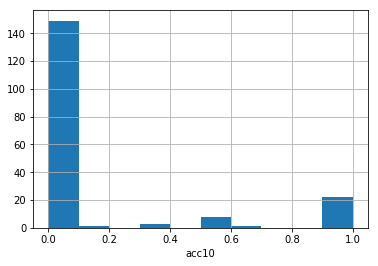

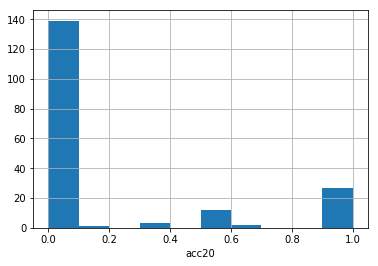

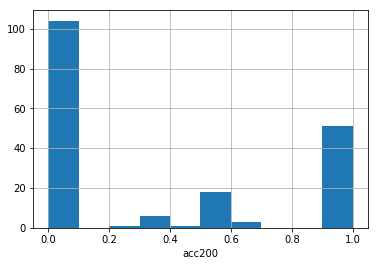

In [71]:
result = evaluate(preds, gold)

ax = result['acc10'].hist()
ax.set_xlabel("acc10")
plt.show()

ax = result['acc20'].hist()
ax.set_xlabel("acc20")
plt.show()

ax = result['acc200'].hist()
ax.set_xlabel("acc200")
plt.show()

In [72]:
k = '59a7bc6a782b1b893a56a87e'
print(k)
preds[k]

59a7bc6a782b1b893a56a87e


['5984cf94b6b11336826384f7',
 '5984d255b6b113502e638505',
 '5984dd40b6b11333bc6384f9',
 '5984d809b6b11308f96384f7',
 '5984d808b6b11308f36384f2',
 '5984d809b6b11308f96384f6',
 '5984ba57b6b1134c4463851c',
 '5984d4fbb6b1136a5363850d',
 '5984d0c0b6b113406f638501',
 '5984cb09b6b1130b8e638508',
 '5984bdd5b6b1137588638508',
 '5984c712b6b113633963850b',
 '5984d808b6b11308f36384f5',
 '5984cd24b6b1132019638521',
 '5984c4ddb6b11349ac638508',
 '5984df2cb6b1133e9263851f',
 '5984d80cb6b11308fc63850c',
 '5984baaab6b1134e9f63854b',
 '5984befab6b11303e4638520',
 '5984d248b6b1134f2263852c',
 '5984bdfbb6b11376f2638504',
 '5984d714b6b1137f35638521',
 '5984d25db6b113504a63851c',
 '5984d25ab6b113503c638518',
 '5984d425b6b11363a363851e',
 '5984defbb6b1133d3963852c',
 '5984bd53b6b11370ca63851f',
 '5984cad9b6b11309676384f1',
 '5984bff7b6b1130db163853a',
 '5984be6db6b1137db763850a',
 '5984bbb0b6b1135c366384fe',
 '5984d233b6b1134e44638510',
 '5984c17cb6b1132203638526',
 '5984c3e2b6b113412d6384ff',
 '5984ce68b6b1

In [73]:
predict([k], lim=10**9)[k].index('5984ccc4b6b1131d6a63850e')

354

# Develop

In [83]:
g = tf.Graph()
with g.as_default():
    tf.set_random_seed(0)
    sess = tf.Session()
    with sess.as_default():

        arr = np.array([[1,2,3], [4,5,6], [7,8,9]], dtype=np.float32)
        
        m = tf.nn.l2_normalize(arr, dim=1)
        
        sess.run(tf.global_variables_initializer())
        
        [res] = sess.run([m])
        print(res)


[[ 0.26726124  0.53452247  0.80178368]
 [ 0.45584232  0.56980288  0.6837635 ]
 [ 0.50257069  0.57436651  0.64616233]]


In [84]:
np.array([1.,2.,3.])/np.sqrt(1+4+9)

array([ 0.26726124,  0.53452248,  0.80178373])

In [81]:
0.26726124**2 + 0.53452247**2 + 0.80178368**2

0.9999999108555808